In [1]:
%matplotlib inline

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd
import copy
from pyquaternion import Quaternion

In [3]:
import math

def quaternion_to_euler(w, x, y, z):
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        X = math.degrees(math.atan2(t0, t1))

        t2 = +2.0 * (w * y - z * x)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        Y = math.degrees(math.asin(t2))

        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        Z = math.degrees(math.atan2(t3, t4))

        return X, Y, Z
    
    
def quaternion_to_euler_2(w, x, y, z):    
    sqw = w*w
    sqx = x*x
    sqy = y*y
    sqz = z*z
    unit = sqx + sqy + sqz + sqw # if normalised is one, otherwise is correction factor
    test = x*y + z*w
    if test > 0.499*unit: # singularity at north pole
        heading = 2 * math.atan2(x,w)
        attitude = math.pi/2
        bank = 0
        return heading, attitude, bank

    if test < -0.499*unit: # singularity at south pole
        heading = -2 * math.atan2(x,w)
        attitude = -math.pi/2
        bank = 0
        return heading, attitude, bank

    heading = math.atan2(2*y*w-2*x*z , sqx - sqy - sqz + sqw)
    attitude = math.asin(2*test/unit)
    bank = math.atan2(2*x*w-2*y*z , -sqx + sqy - sqz + sqw)
    return heading, attitude, bank

In [4]:
mydf = pd.read_csv('C:\IAAA\TER\data\ACORFORMED\Data\N7A\Casque\Unity\N7A-Casque-Unity-out_record_DATE17-2-27_13-29-57.txt', sep='\t')
points_subject = ['HeadSubject', 'LeftWristSubject', 'RightWristSubject', 'LeftElbowSubject', 'RightElbowSubject', 'master']
points_agent = ['Head', 'LeftHand', 'RightHand', 'LeftArm', 'RightArm', 'master']
points = points_subject
df = mydf

In [11]:
all = []
points = points_agent
for point in points:
    all.append(point+'_posx')
    all.append(point+'_posy')
    all.append(point+'_posz')
    all.append(point+'_quax')
    all.append(point+'_quay')
    all.append(point+'_quaz')    
    all.append(point+'_quaw')    
df = mydf.drop_duplicates(subset=all)
print(len(df))

4606


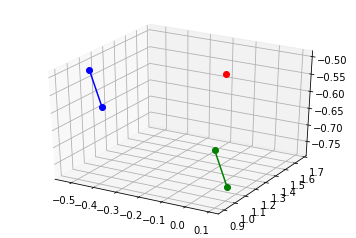

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data = df.iloc[0]

# head
ax.plot([data[points[0]+'_posx']], [data[points[0]+'_posy']], [data[points[0]+'_posz']], linestyle="", marker='o', c='r') 
ax.plot([data[points[1]+'_posx'], data[points[3]+'_posx']], [data[points[1]+'_posy'], data[points[3]+'_posy']], [data[points[1]+'_posz'], data[points[3]+'_posz']], linestyle="-", marker='o', c='b')
ax.plot([data[points[2]+'_posx'], data[points[4]+'_posx']], [data[points[2]+'_posy'], data[points[4]+'_posy']], [data[points[2]+'_posz'], data[points[4]+'_posz']], linestyle="-", marker='o', c='g')

12759


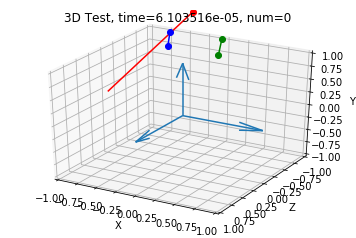

In [6]:
print(len(df))
df = mydf

#a = np.random.rand(2000, 3)*10
#t = np.array([np.ones(100)*i for i in range(20)]).flatten()
#df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
#print(a)
#print(t)
points_subject = ['HeadSubject', 'LeftWristSubject', 'RightWristSubject', 'LeftElbowSubject', 'RightElbowSubject']
points_agent = ['Head', 'LeftHand', 'RightHand', 'LeftArm', 'RightArm']
markers = ['D', 'o', '<', '>', '3', '4', 'x']
colors = ['r', 'orange', 'g', 'g', 'b', 'b', 'black']
graphs = []

points = points_subject
type = 'p'

def vect(v):
    u = copy.copy(v)
    # switch Y and Z axis
    u[1] = v[2]
    u[2] = v[1]
    """if isinstance(v[1], basestring):
        u[2] = v[1]
    else:
        u[2] = -v[1]"""
    return u

def get_quaternion(df, num, point):
    data = df.iloc[num]
    return Quaternion(w=data[point+'_quaw'], x=data[point+'_quax'], y=data[point+'_quay'], z=data[point+'_quaz'])

def get_coords_q(df, num, point):
    data=df.iloc[num]
    v = np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']])
    q = get_quaternion(df, num, point)
    v = q.rotate(v)
    return vect(v)

def get_coords_p(df, num, point):
    data=df.iloc[num]
    #print(np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']]))
    return vect(np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']]))

def get_coords(df, num, point):
    if type == 'p':
        return get_coords_p(df, num, point)
    else:
        return get_coords_q(df, num, point)

def update_graph(num):
    data=df.iloc[num]
    """for idx, point in enumerate(points):
        #x = data[[col+'_posx' for col in points]]
        #y = data[[col+'_posy' for col in points]]
        #z = data[[col+'_posz' for col in points]]
        v = np.array([data[point+'_posx'], data[point+'_posy'], data[point+'_posz']])
        q = Quaternion(x=data[point+'_quax'], y=data[point+'_quay'], z=data[point+'_quaz'], w=data[point+'_quaw'])
        v = q.rotate(v)
        graphs[idx].set_data (v[0], v[1])
        graphs[idx].set_3d_properties(v[2])"""
    v = get_coords(df, num, points[0])
    head.set_data(v[0], v[1])
    head.set_3d_properties(v[2])
    
    q = get_quaternion(df, num, points[0])
    hv = q.rotate([1,0,0])
    head_orientation.set_segments([[ [v[0], v[1], v[2]], [hv[0], hv[1], hv[2]] ]])
    #= ax.quiver(v[0], v[1], v[2], hv[0], hv[1], hv[2], color='r')    
    
    v1 = get_coords(df, num, points[1])
    v2 = get_coords(df, num, points[3])
    left.set_data([v1[0], v2[0]], [v1[1], v2[1]])
    left.set_3d_properties([v1[2], v2[2]])
    v1 = get_coords(df, num, points[2])
    v2 = get_coords(df, num, points[4])
    right.set_data([v1[0], v2[0]], [v1[1], v2[1]])
    right.set_3d_properties([v1[2], v2[2]])
        
    title.set_text('3D Test, time={}, num={}'.format(data['chrono'], num))
    return title, head, left, right


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df.iloc[0]
#df[df['chrono']==0]
#graphs = [ax.plot([data[point+'_posx']], [data[point+'_posy']], [data[point+'_posz']], linestyle="", marker=markers[idx], c=colors[idx])[0] for idx, point in enumerate(points)]

graphs = []
v = get_coords(df, 0, points[0])
head = ax.plot([v[0]], [v[1]], [v[2]], linestyle="", marker='o', c='r')[0]

q = get_quaternion(df, 0, points[0])
hv = q.rotate([1,0,0])
head_orientation = ax.quiver(v[0], v[1], v[2], hv[0], hv[1], hv[2], color='r')


v1 = get_coords(df, 0, points[1])
v2 = get_coords(df, 0, points[3])
left = ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], linestyle="-", marker='o', c='b')[0]
v1 = get_coords(df, 0, points[2])
v2 = get_coords(df, 0, points[4])
right = ax.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], linestyle="-", marker='o', c='g')[0]




#print(graphs)

#graph, = ax.plot([data[point+'_posx']], [data[point+'_posy']], [data[point+'_posz']], linestyle="", marker="o")
#ax.set_xlim(xmin=df[point+'_posx'].min(), xmax=df[point+'_posx'].max())
#ax.set_ylim(ymin=df[point+'_posy'].min(), ymax=df[point+'_posy'].max())
#ax.set_zlim(zmin=df[point+'_posz'].min(), zmax=df[point+'_posz'].max())
#print(np.amin(df[[col+'_posx' for col in points]].values))

#ax.set_xlim(np.amin(df[[col+'_posx' for col in points]].values), np.amax(df[[col+'_posx' for col in points]].max(axis=None).values))
#ax.set_ylim(np.amin(df[[col+'_posy' for col in points]].values), np.amax(df[[col+'_posy' for col in points]].max(axis=None).values))
#ax.set_zlim(np.amin(df[[col+'_posz' for col in points]].values), np.amax(df[[col+'_posz' for col in points]].max(axis=None).values))

dim = 1
ax.set_xlim(-dim, dim)
ax.set_ylim(dim, -dim)
ax.set_zlim(-dim, dim)
coords = ['X', 'Y', 'Z']
ax.set_xlabel(vect(coords)[0])
ax.set_ylabel(vect(coords)[1])
ax.set_zlabel(vect(coords)[2])

x = [0,0,0]
u = [1,0,0]
v = [0,1,0]
w = [0,0,1]
ax.quiver(x, x, x, vect(u), vect(v), vect(w))

ani = matplotlib.animation.FuncAnimation(fig, update_graph, np.arange(0, len(df), 1), 
                                interval=10, blit=True)

plt.show()

In [8]:
from IPython.core.display import display, HTML
point = 'Head'
#q = [get_quaternion(df, num, point) for num in np.arange(len(df))]


d = df[['chrono', point+'_quax', point+'_quay', point+'_quaz', point+'_quaw']]
d = d.drop_duplicates()
print(len(d))
#display(HTML(d[['HeadSubject_quax', 'HeadSubject_quay', 'HeadSubject_quaz', 'HeadSubject_quaw']].to_html()))
accel = np.zeros((len(df), 3), dtype='float64')
angles = np.zeros((len(df), 3), dtype='float64')
pyaw, ppitch, proll = 0,0,0
for i in np.arange(len(df)):
    q = get_quaternion(d, i, point)
    #print("%f / %s / axis %s angle %f / %f, %f, %f, %f" % (d['chrono'].iloc[i], str(q), str(q.axis), q.angle, d.iloc[i][point+'_quax'], d.iloc[i][point+'_quay'], d.iloc[i][point+'_quaz'], d.iloc[i][point+'_quaw']))
    #x,y,z,w = d.iloc[i]['HeadSubject_quax'], d.iloc[i]['HeadSubject_quay'], d.iloc[i]['HeadSubject_quaz'], d.iloc[i]['HeadSubject_quaw']
    print("x %f y %f z %f w %f" % (q.x,q.y,q.z,q.w))
    #q = Quaternion(x,y,z,w)
    print("axis %s angle %f" % (q.axis, q.angle))
    yaw, pitch, roll = quaternion_to_euler_2(q.w, q.x, q.y, q.z)
    yaw, pitch, roll = abs(yaw), abs(pitch), abs(roll)
    if i == 0:
        pyaw, ppitch, proll = yaw, pitch, roll
    #print('yaw %f pitch %f roll %f' % (yaw, pitch, roll))
    accel[i,:] = [yaw-pyaw, pitch-ppitch, roll-proll]
    angles[i,:] = [yaw, pitch, roll]
    print('yaw %f %f %f' % (pyaw, yaw, yaw-pyaw))
    pyaw, ppitch, proll = yaw,pitch,roll
#print('MEAN %s STD %s' % (str(np.mean(angles, axis=1)), str(np.std(angles, axis=1))))
display(HTML(pd.DataFrame(data=angles, columns=['yaw', 'pitch', 'roll']).describe().to_html()))
display(HTML(pd.DataFrame(data=accel, columns=['yaw a', 'pitch a', 'roll a']).describe().to_html()))
"""a1 = [qua.axis[0] for qua in q]
a2 = [qua.axis[1] for qua in q]
a3 = [qua.axis[2] for qua in q]
angle = [qua.angle for qua in q]
plt.plot(df['chrono'], a1, label='rot x')
plt.plot(df['chrono'], a2, label='rot y')
plt.plot(df['chrono'], a3, label='rot z')
plt.plot(df['chrono'], angle, label='rot angle')"""
#plt.plot(df['chrono'], df[point+'_posx'], label=point+'_posx')
#plt.plot(df['chrono'], df[point+'_posy'], label=point+'_posy')
#plt.plot(df['chrono'], df[point+'_posz'], label=point+'_posz')
"""plt.plot(df['chrono'], angles[:, 0], label='yaw')
plt.legend()
plt.show()"""



12759
x -0.030410 y 0.202200 z 0.004253 w 0.978863
axis [-0.14868913  0.98866533  0.02079462] angle 0.411943
yaw 0.407281 0.407281 0.000000
x -0.030410 y 0.202200 z 0.004253 w 0.978863
axis [-0.14868913  0.98866533  0.02079462] angle 0.411943
yaw 0.407281 0.407281 0.000000
x -0.030410 y 0.202200 z 0.004253 w 0.978863
axis [-0.14868913  0.98866533  0.02079462] angle 0.411943
yaw 0.407281 0.407281 0.000000
x -0.030389 y 0.202441 z 0.004244 w 0.978814
axis [-0.14841895  0.98870738  0.02072503] angle 0.412424
yaw 0.407281 0.407773 0.000492
x -0.030389 y 0.202441 z 0.004244 w 0.978814
axis [-0.14841895  0.98870738  0.02072503] angle 0.412424
yaw 0.407773 0.407773 0.000000
x -0.030389 y 0.202441 z 0.004244 w 0.978814
axis [-0.14841895  0.98870738  0.02072503] angle 0.412424
yaw 0.407773 0.407773 0.000000
x -0.030353 y 0.202715 z 0.004225 w 0.978758
axis [-0.14804905  0.98876524  0.02061019] angle 0.412964
yaw 0.407773 0.408330 0.000557
x -0.030353 y 0.202715 z 0.004225 w 0.978758
axis [-0.14

yaw 0.409514 0.409416 -0.000098
x -0.061931 y 0.203441 z 0.003508 w 0.977120
axis [-0.29118237  0.95652539  0.0164925 ] angle 0.428649
yaw 0.409416 0.409416 0.000000
x -0.061931 y 0.203441 z 0.003508 w 0.977120
axis [-0.29118237  0.95652539  0.0164925 ] angle 0.428649
yaw 0.409416 0.409416 0.000000
x -0.062818 y 0.203475 z 0.003625 w 0.977056
axis [-0.29494387  0.95536297  0.01702086] angle 0.429252
yaw 0.409416 0.409484 0.000069
x -0.062818 y 0.203475 z 0.003625 w 0.977056
axis [-0.29494387  0.95536297  0.01702086] angle 0.429252
yaw 0.409484 0.409484 0.000000
x -0.063623 y 0.203547 z 0.003748 w 0.976989
axis [-0.29829155  0.95431305  0.01757121] angle 0.429887
yaw 0.409484 0.409633 0.000148
x -0.063623 y 0.203547 z 0.003748 w 0.976989
axis [-0.29829155  0.95431305  0.01757121] angle 0.429887
yaw 0.409633 0.409633 0.000000
x -0.063623 y 0.203547 z 0.003748 w 0.976989
axis [-0.29829155  0.95431305  0.01757121] angle 0.429887
yaw 0.409633 0.409633 0.000000
x -0.064345 y 0.203632 z 0.003

x -0.072686 y 0.207728 z 0.010810 w 0.975423
axis [-0.3298785   0.94274774  0.04905982] angle 0.444332
yaw 0.418801 0.418985 0.000184
x -0.072686 y 0.207728 z 0.010810 w 0.975423
axis [-0.3298785   0.94274774  0.04905982] angle 0.444332
yaw 0.418985 0.418985 0.000000
x -0.072429 y 0.207823 z 0.010748 w 0.975422
axis [-0.32870661  0.94317164  0.04877721] angle 0.444335
yaw 0.418985 0.419171 0.000186
x -0.072429 y 0.207823 z 0.010748 w 0.975422
axis [-0.32870661  0.94317164  0.04877721] angle 0.444335
yaw 0.419171 0.419171 0.000000
x -0.072429 y 0.207823 z 0.010748 w 0.975422
axis [-0.32870661  0.94317164  0.04877721] angle 0.444335
yaw 0.419171 0.419171 0.000000
x -0.072175 y 0.207914 z 0.010673 w 0.975422
axis [-0.32755519  0.94358952  0.04843973] angle 0.444334
yaw 0.419171 0.419349 0.000178
x -0.072175 y 0.207914 z 0.010673 w 0.975422
axis [-0.32755519  0.94358952  0.04843973] angle 0.444334
yaw 0.419349 0.419349 0.000000
x -0.072175 y 0.207914 z 0.010673 w 0.975422
axis [-0.32755519

axis [-0.29482346  0.95450645  0.04468282] angle 0.450331
yaw 0.429912 0.429912 0.000000
x -0.065772 y 0.212870 z 0.010032 w 0.974813
axis [-0.2949071   0.9544666   0.04498117] angle 0.449832
yaw 0.429912 0.429428 -0.000485
x -0.065772 y 0.212870 z 0.010032 w 0.974813
axis [-0.2949071   0.9544666   0.04498117] angle 0.449832
yaw 0.429428 0.429428 0.000000
x -0.065772 y 0.212870 z 0.010032 w 0.974813
axis [-0.2949071   0.9544666   0.04498117] angle 0.449832
yaw 0.429428 0.429428 0.000000
x -0.065740 y 0.212625 z 0.010078 w 0.974868
axis [-0.29508477  0.95439969  0.04523509] angle 0.449338
yaw 0.429428 0.428934 -0.000494
x -0.065740 y 0.212625 z 0.010078 w 0.974868
axis [-0.29508477  0.95439969  0.04523509] angle 0.449338
yaw 0.428934 0.428934 0.000000
x -0.065740 y 0.212625 z 0.010078 w 0.974868
axis [-0.29508477  0.95439969  0.04523509] angle 0.449338
yaw 0.428934 0.428934 0.000000
x -0.065726 y 0.212368 z 0.010117 w 0.974924
axis [-0.29534778  0.95430763  0.04546036] angle 0.448831
ya

x -0.071498 y 0.202180 z 0.003500 w 0.976729
axis [-0.33335815  0.94265902  0.016319  ] angle 0.432316
yaw 0.406664 0.406664 0.000000
x -0.071498 y 0.202180 z 0.003500 w 0.976729
axis [-0.33335815  0.94265902  0.016319  ] angle 0.432316
yaw 0.406664 0.406664 0.000000
x -0.072123 y 0.202093 z 0.003441 w 0.976701
axis [-0.33607578  0.94169844  0.01603475] angle 0.432573
yaw 0.406664 0.406464 -0.000200
x -0.072123 y 0.202093 z 0.003441 w 0.976701
axis [-0.33607578  0.94169844  0.01603475] angle 0.432573
yaw 0.406464 0.406464 0.000000
x -0.072123 y 0.202093 z 0.003441 w 0.976701
axis [-0.33607578  0.94169844  0.01603475] angle 0.432573
yaw 0.406464 0.406464 0.000000
x -0.072730 y 0.202044 z 0.003386 w 0.976666
axis [-0.33865491  0.94077858  0.01576428] angle 0.432897
yaw 0.406464 0.406344 -0.000120
x -0.072730 y 0.202044 z 0.003386 w 0.976666
axis [-0.33865491  0.94077858  0.01576428] angle 0.432897
yaw 0.406344 0.406344 0.000000
x -0.072730 y 0.202044 z 0.003386 w 0.976666
axis [-0.338654

yaw 0.425001 0.425475 0.000473
x -0.060448 y 0.211107 z 0.006814 w 0.975568
axis [-0.27514403  0.96090257  0.03101648] angle 0.443007
yaw 0.425475 0.425475 0.000000
x -0.060448 y 0.211107 z 0.006814 w 0.975568
axis [-0.27514403  0.96090257  0.03101648] angle 0.443007
yaw 0.425475 0.425475 0.000000
x -0.060030 y 0.211319 z 0.006780 w 0.975549
axis [-0.27313115  0.96148206  0.03084829] angle 0.443187
yaw 0.425475 0.425908 0.000433
x -0.060030 y 0.211319 z 0.006780 w 0.975549
axis [-0.27313115  0.96148206  0.03084829] angle 0.443187
yaw 0.425908 0.425908 0.000000
x -0.059652 y 0.211514 z 0.006743 w 0.975530
axis [-0.27130932  0.96200344  0.03066973] angle 0.443358
yaw 0.425908 0.426306 0.000398
x -0.059652 y 0.211514 z 0.006743 w 0.975530
axis [-0.27130932  0.96200344  0.03066973] angle 0.443358
yaw 0.426306 0.426306 0.000000
x -0.059652 y 0.211514 z 0.006743 w 0.975530
axis [-0.27130932  0.96200344  0.03066973] angle 0.443358
yaw 0.426306 0.426306 0.000000
x -0.059320 y 0.211709 z 0.0067

x -0.055142 y 0.206918 z 0.006090 w 0.976784
axis [-0.25740203  0.9658861   0.02842943] angle 0.431798
yaw 0.416545 0.416895 0.000350
x -0.055142 y 0.206918 z 0.006090 w 0.976784
axis [-0.25740203  0.9658861   0.02842943] angle 0.431798
yaw 0.416895 0.416895 0.000000
x -0.054653 y 0.207072 z 0.006059 w 0.976779
axis [-0.25509113  0.96650338  0.02827968] angle 0.431844
yaw 0.416895 0.417211 0.000316
x -0.054653 y 0.207072 z 0.006059 w 0.976779
axis [-0.25509113  0.96650338  0.02827968] angle 0.431844
yaw 0.417211 0.417211 0.000000
x -0.054653 y 0.207072 z 0.006059 w 0.976779
axis [-0.25509113  0.96650338  0.02827968] angle 0.431844
yaw 0.417211 0.417211 0.000000
x -0.054154 y 0.207215 z 0.006028 w 0.976777
axis [-0.25275038  0.96712235  0.02813538] angle 0.431867
yaw 0.417211 0.417506 0.000294
x -0.054154 y 0.207215 z 0.006028 w 0.976777
axis [-0.25275038  0.96712235  0.02813538] angle 0.431867
yaw 0.417506 0.417506 0.000000
x -0.054154 y 0.207215 z 0.006028 w 0.976777
axis [-0.25275038

x -0.052399 y 0.198087 z 0.009091 w 0.978741
axis [-0.25547717  0.9657986   0.04432242] angle 0.413135
yaw 0.398163 0.399226 0.001063
x -0.052399 y 0.198087 z 0.009091 w 0.978741
axis [-0.25547717  0.9657986   0.04432242] angle 0.413135
yaw 0.399226 0.399226 0.000000
x -0.052399 y 0.198087 z 0.009091 w 0.978741
axis [-0.25547717  0.9657986   0.04432242] angle 0.413135
yaw 0.399226 0.399226 0.000000
x -0.051814 y 0.198674 z 0.008935 w 0.978654
axis [-0.25211791  0.96671948  0.04347426] angle 0.413978
yaw 0.399226 0.400409 0.001183
x -0.051814 y 0.198674 z 0.008935 w 0.978654
axis [-0.25211791  0.96671948  0.04347426] angle 0.413978
yaw 0.400409 0.400409 0.000000
x -0.051814 y 0.198674 z 0.008935 w 0.978654
axis [-0.25211791  0.96671948  0.04347426] angle 0.413978
yaw 0.400409 0.400409 0.000000
x -0.051325 y 0.199299 z 0.008781 w 0.978554
axis [-0.24916234  0.96752308  0.04262874] angle 0.414949
yaw 0.400409 0.401668 0.001259
x -0.051325 y 0.199299 z 0.008781 w 0.978554
axis [-0.24916234

axis [-0.22012656  0.97510243  0.02682432] angle 0.393406
yaw 0.384660 0.383589 -0.001071
x -0.043021 y 0.190571 z 0.005242 w 0.980716
axis [-0.22012656  0.97510243  0.02682432] angle 0.393406
yaw 0.383589 0.383589 0.000000
x -0.043021 y 0.190571 z 0.005242 w 0.980716
axis [-0.22012656  0.97510243  0.02682432] angle 0.393406
yaw 0.383589 0.383589 0.000000
x -0.042925 y 0.190201 z 0.005217 w 0.980792
axis [-0.22006745  0.9751179   0.0267468 ] angle 0.392625
yaw 0.383589 0.382833 -0.000756
x -0.042925 y 0.190201 z 0.005217 w 0.980792
axis [-0.22006745  0.9751179   0.0267468 ] angle 0.392625
yaw 0.382833 0.382833 0.000000
x -0.042925 y 0.190201 z 0.005217 w 0.980792
axis [-0.22006745  0.9751179   0.0267468 ] angle 0.392625
yaw 0.382833 0.382833 0.000000
x -0.042846 y 0.189931 z 0.005193 w 0.980849
axis [-0.21998     0.97513994  0.02666274] angle 0.392051
yaw 0.382833 0.382281 -0.000552
x -0.042846 y 0.189931 z 0.005193 w 0.980849
axis [-0.21998     0.97513994  0.02666274] angle 0.392051
y

x -0.050320 y 0.200143 z 0.006759 w 0.978450
axis [-0.24370161  0.96929768  0.03273425] angle 0.415957
yaw 0.403184 0.403184 0.000000
x -0.050320 y 0.200143 z 0.006759 w 0.978450
axis [-0.24370161  0.96929768  0.03273425] angle 0.415957
yaw 0.403184 0.403184 0.000000
x -0.050384 y 0.200404 z 0.006852 w 0.978393
axis [-0.24369091  0.96928662  0.03313894] angle 0.416512
yaw 0.403184 0.403726 0.000541
x -0.050384 y 0.200404 z 0.006852 w 0.978393
axis [-0.24369091  0.96928662  0.03313894] angle 0.416512
yaw 0.403726 0.403726 0.000000
x -0.050418 y 0.200665 z 0.006941 w 0.978337
axis [-0.24354485  0.96930986  0.03353059] angle 0.417052
yaw 0.403726 0.404266 0.000540
x -0.050418 y 0.200665 z 0.006941 w 0.978337
axis [-0.24354485  0.96930986  0.03353059] angle 0.417052
yaw 0.404266 0.404266 0.000000
x -0.050418 y 0.200665 z 0.006941 w 0.978337
axis [-0.24354485  0.96930986  0.03353059] angle 0.417052
yaw 0.404266 0.404266 0.000000
x -0.050415 y 0.200937 z 0.007037 w 0.978281
axis [-0.24321853

x -0.045965 y 0.189165 z 0.008775 w 0.980830
axis [-0.23587863  0.97073869  0.04502974] angle 0.392244
yaw 0.381038 0.381038 0.000000
x -0.045965 y 0.189165 z 0.008775 w 0.980830
axis [-0.23587863  0.97073869  0.04502974] angle 0.392244
yaw 0.381038 0.381038 0.000000
x -0.045804 y 0.189362 z 0.008584 w 0.980801
axis [-0.2348794   0.9710273   0.04401875] angle 0.392540
yaw 0.381038 0.381421 0.000383
x -0.045804 y 0.189362 z 0.008584 w 0.980801
axis [-0.2348794   0.9710273   0.04401875] angle 0.392540
yaw 0.381421 0.381421 0.000000
x -0.045804 y 0.189362 z 0.008584 w 0.980801
axis [-0.2348794   0.9710273   0.04401875] angle 0.392540
yaw 0.381421 0.381421 0.000000
x -0.045688 y 0.189589 z 0.008381 w 0.980764
axis [-0.2340616   0.97127317  0.0429372 ] angle 0.392916
yaw 0.381421 0.381863 0.000442
x -0.045688 y 0.189589 z 0.008381 w 0.980764
axis [-0.2340616   0.97127317  0.0429372 ] angle 0.392916
yaw 0.381863 0.381863 0.000000
x -0.045688 y 0.189589 z 0.008381 w 0.980764
axis [-0.2340616 

yaw 0.419503 0.423429 0.003925
x -0.051072 y 0.210336 z 0.001110 w 0.976294
axis [-0.23595192  0.97175121  0.00512698] angle 0.436354
yaw 0.423429 0.423429 0.000000
x -0.051235 y 0.212152 z 0.001267 w 0.975892
axis [-0.23474711  0.97203913  0.00580652] angle 0.440051
yaw 0.423429 0.427153 0.003724
x -0.051235 y 0.212152 z 0.001267 w 0.975892
axis [-0.23474711  0.97203913  0.00580652] angle 0.440051
yaw 0.427153 0.427153 0.000000
x -0.051235 y 0.212152 z 0.001267 w 0.975892
axis [-0.23474711  0.97203913  0.00580652] angle 0.440051
yaw 0.427153 0.427153 0.000000
x -0.051377 y 0.213890 z 0.001434 w 0.975505
axis [-0.23355333  0.97232215  0.00651793] angle 0.443586
yaw 0.427153 0.430721 0.003568
x -0.051377 y 0.213890 z 0.001434 w 0.975505
axis [-0.23355333  0.97232215  0.00651793] angle 0.443586
yaw 0.430721 0.430721 0.000000
x -0.051377 y 0.213890 z 0.001434 w 0.975505
axis [-0.23355333  0.97232215  0.00651793] angle 0.443586
yaw 0.430721 0.430721 0.000000
x -0.051499 y 0.215485 z 0.0015

x -0.051374 y 0.214588 z 0.010752 w 0.975293
axis [-0.23255226  0.97136524  0.04867251] angle 0.445502
yaw 0.433089 0.433089 0.000000
x -0.051009 y 0.214541 z 0.010586 w 0.975325
axis [-0.23104663  0.97176042  0.04794929] angle 0.445219
yaw 0.433089 0.432976 -0.000113
x -0.051009 y 0.214541 z 0.010586 w 0.975325
axis [-0.23104663  0.97176042  0.04794929] angle 0.445219
yaw 0.432976 0.432976 0.000000
x -0.050656 y 0.214511 z 0.010412 w 0.975351
axis [-0.22956731  0.97214829  0.04718645] angle 0.444976
yaw 0.432976 0.432897 -0.000078
x -0.050656 y 0.214511 z 0.010412 w 0.975351
axis [-0.22956731  0.97214829  0.04718645] angle 0.444976
yaw 0.432897 0.432897 0.000000
x -0.050656 y 0.214511 z 0.010412 w 0.975351
axis [-0.22956731  0.97214829  0.04718645] angle 0.444976
yaw 0.432897 0.432897 0.000000
x -0.050317 y 0.214482 z 0.010256 w 0.975377
axis [-0.22814872  0.97251506  0.04650409] angle 0.444744
yaw 0.432897 0.432823 -0.000075
x -0.050317 y 0.214482 z 0.010256 w 0.975377
axis [-0.22814

x -0.046556 y 0.198158 z 0.001216 w 0.979063
axis [-0.22871137  0.97347596  0.0059724 ] angle 0.409980
yaw 0.398658 0.398658 0.000000
x -0.046556 y 0.198158 z 0.001216 w 0.979063
axis [-0.22871137  0.97347596  0.0059724 ] angle 0.409980
yaw 0.398658 0.398658 0.000000
x -0.046557 y 0.198521 z 0.001158 w 0.978990
axis [-0.22832257  0.97356898  0.00567896] angle 0.410701
yaw 0.398658 0.399393 0.000735
x -0.046557 y 0.198521 z 0.001158 w 0.978990
axis [-0.22832257  0.97356898  0.00567896] angle 0.410701
yaw 0.399393 0.399393 0.000000
x -0.046557 y 0.198521 z 0.001158 w 0.978990
axis [-0.22832257  0.97356898  0.00567896] angle 0.410701
yaw 0.399393 0.399393 0.000000
x -0.046593 y 0.198879 z 0.001112 w 0.978915
axis [-0.22809635  0.97362334  0.00544465] angle 0.411430
yaw 0.399393 0.400119 0.000726
x -0.046593 y 0.198879 z 0.001112 w 0.978915
axis [-0.22809635  0.97362334  0.00544465] angle 0.411430
yaw 0.400119 0.400119 0.000000
x -0.046660 y 0.199245 z 0.001069 w 0.978838
axis [-0.22801091

yaw 0.401101 0.401101 0.000000
x -0.010831 y 0.199189 z 0.002852 w 0.979897
axis [-0.0542899   0.99842285  0.01429765] angle 0.401703
yaw 0.401101 0.401101 0.000000
x -0.008502 y 0.198618 z 0.002822 w 0.980036
axis [-0.04276326  0.99898442  0.01419249] angle 0.400306
yaw 0.401101 0.399930 -0.001171
x -0.008502 y 0.198618 z 0.002822 w 0.980036
axis [-0.04276326  0.99898442  0.01419249] angle 0.400306
yaw 0.399930 0.399930 0.000000
x -0.008502 y 0.198618 z 0.002822 w 0.980036
axis [-0.04276326  0.99898442  0.01419249] angle 0.400306
yaw 0.399930 0.399930 0.000000
x -0.006201 y 0.198006 z 0.002789 w 0.980177
axis [-0.03129768  0.99941099  0.0140756 ] angle 0.398884
yaw 0.399930 0.398675 -0.001255
x -0.006201 y 0.198006 z 0.002789 w 0.980177
axis [-0.03129768  0.99941099  0.0140756 ] angle 0.398884
yaw 0.398675 0.398675 0.000000
x -0.006201 y 0.198006 z 0.002789 w 0.980177
axis [-0.03129768  0.99941099  0.0140756 ] angle 0.398884
yaw 0.398675 0.398675 0.000000
x -0.004014 y 0.197348 z 0.00

axis [ 0.04400754  0.9986277  -0.02839107] angle 0.392920
yaw 0.392466 0.392466 0.000000
x 0.008590 y 0.194931 z -0.005542 w 0.980764
axis [ 0.04400754  0.9986277  -0.02839107] angle 0.392920
yaw 0.392466 0.392466 0.000000
x 0.008750 y 0.194598 z -0.005732 w 0.980827
axis [ 0.04489816  0.99855848 -0.02941277] angle 0.392269
yaw 0.392466 0.391794 -0.000672
x 0.008750 y 0.194598 z -0.005732 w 0.980827
axis [ 0.04489816  0.99855848 -0.02941277] angle 0.392269
yaw 0.391794 0.391794 0.000000
x 0.008750 y 0.194598 z -0.005732 w 0.980827
axis [ 0.04489816  0.99855848 -0.02941277] angle 0.392269
yaw 0.391794 0.391794 0.000000
x 0.008864 y 0.194330 z -0.005907 w 0.980878
axis [ 0.04554671  0.99850103 -0.03035117] angle 0.391744
yaw 0.391794 0.391251 -0.000543
x 0.008864 y 0.194330 z -0.005907 w 0.980878
axis [ 0.04554671  0.99850103 -0.03035117] angle 0.391744
yaw 0.391251 0.391251 0.000000
x 0.008947 y 0.194133 z -0.006059 w 0.980916
axis [ 0.04601501  0.99845452 -0.03116379] angle 0.391360
ya

axis [ 0.03669866  0.99904078 -0.02388999] angle 0.400478
yaw 0.400156 0.400156 0.000000
x 0.007299 y 0.198713 z -0.004752 w 0.980019
axis [ 0.03669866  0.99904078 -0.02388999] angle 0.400478
yaw 0.400156 0.400156 0.000000
x 0.007281 y 0.198881 z -0.004786 w 0.979985
axis [ 0.03657246  0.99904182 -0.02403956] angle 0.400821
yaw 0.400156 0.400500 0.000344
x 0.007281 y 0.198881 z -0.004786 w 0.979985
axis [ 0.03657246  0.99904182 -0.02403956] angle 0.400821
yaw 0.400500 0.400500 0.000000
x 0.007281 y 0.198881 z -0.004786 w 0.979985
axis [ 0.03657246  0.99904182 -0.02403956] angle 0.400821
yaw 0.400500 0.400500 0.000000
x 0.007270 y 0.199035 z -0.004810 w 0.979954
axis [ 0.03648923  0.99904237 -0.02414301] angle 0.401136
yaw 0.400500 0.400815 0.000315
x 0.007270 y 0.199035 z -0.004810 w 0.979954
axis [ 0.03648923  0.99904237 -0.02414301] angle 0.401136
yaw 0.400815 0.400815 0.000000
x 0.007270 y 0.199035 z -0.004810 w 0.979954
axis [ 0.03648923  0.99904237 -0.02414301] angle 0.401136
yaw 

axis [0.00736453 0.99990435 0.01170675] angle 0.415832
yaw 0.414710 0.415788 0.001079
x 0.001520 y 0.206402 z 0.002417 w 0.978463
axis [0.00736453 0.99990435 0.01170675] angle 0.415832
yaw 0.415788 0.415788 0.000000
x 0.001678 y 0.206926 z 0.002567 w 0.978352
axis [0.00810634 0.99989021 0.01240374] angle 0.416910
yaw 0.415788 0.416859 0.001071
x 0.001678 y 0.206926 z 0.002567 w 0.978352
axis [0.00810634 0.99989021 0.01240374] angle 0.416910
yaw 0.416859 0.416859 0.000000
x 0.001678 y 0.206926 z 0.002567 w 0.978352
axis [0.00810634 0.99989021 0.01240374] angle 0.416910
yaw 0.416859 0.416859 0.000000
x 0.001848 y 0.207449 z 0.002714 w 0.978240
axis [0.00890553 0.99987478 0.01308145] angle 0.417986
yaw 0.416859 0.417927 0.001068
x 0.001848 y 0.207449 z 0.002714 w 0.978240
axis [0.00890553 0.99987478 0.01308145] angle 0.417986
yaw 0.417927 0.417927 0.000000
x 0.001848 y 0.207449 z 0.002714 w 0.978240
axis [0.00890553 0.99987478 0.01308145] angle 0.417986
yaw 0.417927 0.417927 0.000000
x 0.

x 0.002813 y 0.190650 z 0.001547 w 0.981653
axis [0.01475236 0.99985825 0.00811527] angle 0.383704
yaw 0.383641 0.383641 0.000000
x 0.002937 y 0.190353 z 0.001411 w 0.981710
axis [0.01542761 0.9998535  0.00741391] angle 0.383100
yaw 0.383641 0.383036 -0.000605
x 0.002937 y 0.190353 z 0.001411 w 0.981710
axis [0.01542761 0.9998535  0.00741391] angle 0.383100
yaw 0.383036 0.383036 0.000000
x 0.002937 y 0.190353 z 0.001411 w 0.981710
axis [0.01542761 0.9998535  0.00741391] angle 0.383100
yaw 0.383036 0.383036 0.000000
x 0.003081 y 0.190160 z 0.001273 w 0.981747
axis [0.01620182 0.99984633 0.00669462] angle 0.382710
yaw 0.383036 0.382642 -0.000394
x 0.003081 y 0.190160 z 0.001273 w 0.981747
axis [0.01620182 0.99984633 0.00669462] angle 0.382710
yaw 0.382642 0.382642 0.000000
x 0.003235 y 0.190046 z 0.001142 w 0.981769
axis [0.01701873 0.99983712 0.00600871] angle 0.382480
yaw 0.382642 0.382409 -0.000233
x 0.003235 y 0.190046 z 0.001142 w 0.981769
axis [0.01701873 0.99983712 0.00600871] ang

x 0.006070 y 0.198992 z -0.000658 w 0.979982
axis [ 0.03048904  0.99952963 -0.00330648] angle 0.400851
yaw 0.399919 0.400660 0.000741
x 0.006070 y 0.198992 z -0.000658 w 0.979982
axis [ 0.03048904  0.99952963 -0.00330648] angle 0.400851
yaw 0.400660 0.400660 0.000000
x 0.006070 y 0.198992 z -0.000658 w 0.979982
axis [ 0.03048904  0.99952963 -0.00330648] angle 0.400851
yaw 0.400660 0.400660 0.000000
x 0.005677 y 0.199360 z -0.000640 w 0.979910
axis [ 0.02846433  0.99958966 -0.00320824] angle 0.401576
yaw 0.400660 0.401410 0.000750
x 0.005677 y 0.199360 z -0.000640 w 0.979910
axis [ 0.02846433  0.99958966 -0.00320824] angle 0.401576
yaw 0.401410 0.401410 0.000000
x 0.005677 y 0.199360 z -0.000640 w 0.979910
axis [ 0.02846433  0.99958966 -0.00320824] angle 0.401576
yaw 0.401410 0.401410 0.000000
x 0.005267 y 0.199698 z -0.000616 w 0.979843
axis [ 0.02636317  0.99964768 -0.00308141] angle 0.402243
yaw 0.401410 0.402100 0.000690
x 0.005267 y 0.199698 z -0.000616 w 0.979843
axis [ 0.02636317

x 0.008056 y 0.197767 z 0.002421 w 0.980213
axis [0.04069688 0.99909667 0.01223116] angle 0.398524
yaw 0.398115 0.398115 0.000000
x 0.007662 y 0.197629 z 0.002630 w 0.980243
axis [0.03873918 0.99916087 0.01329752] angle 0.398215
yaw 0.398115 0.397832 -0.000283
x 0.007662 y 0.197629 z 0.002630 w 0.980243
axis [0.03873918 0.99916087 0.01329752] angle 0.398215
yaw 0.397832 0.397832 0.000000
x 0.007662 y 0.197629 z 0.002630 w 0.980243
axis [0.03873918 0.99916087 0.01329752] angle 0.398215
yaw 0.397832 0.397832 0.000000
x 0.007207 y 0.197520 z 0.002844 w 0.980268
axis [0.03645996 0.99923152 0.01438873] angle 0.397965
yaw 0.397832 0.397612 -0.000220
x 0.007207 y 0.197520 z 0.002844 w 0.980268
axis [0.03645996 0.99923152 0.01438873] angle 0.397965
yaw 0.397612 0.397612 0.000000
x 0.007207 y 0.197520 z 0.002844 w 0.980268
axis [0.03645996 0.99923152 0.01438873] angle 0.397965
yaw 0.397612 0.397612 0.000000
x 0.006709 y 0.197442 z 0.003059 w 0.980287
axis [0.03395344 0.99930351 0.01548102] angl

axis [ 0.05107481  0.99868229 -0.00500465] angle 0.393766
yaw 0.392932 0.393240 0.000308
x 0.009991 y 0.195356 z -0.000979 w 0.980681
axis [ 0.05107481  0.99868229 -0.00500465] angle 0.393766
yaw 0.393240 0.393240 0.000000
x 0.009991 y 0.195356 z -0.000979 w 0.980681
axis [ 0.05107481  0.99868229 -0.00500465] angle 0.393766
yaw 0.393240 0.393240 0.000000
x 0.010389 y 0.195561 z -0.001259 w 0.980636
axis [ 0.0530503   0.99857114 -0.00643052] angle 0.394229
yaw 0.393240 0.393664 0.000424
x 0.010389 y 0.195561 z -0.001259 w 0.980636
axis [ 0.0530503   0.99857114 -0.00643052] angle 0.394229
yaw 0.393664 0.393664 0.000000
x 0.010389 y 0.195561 z -0.001259 w 0.980636
axis [ 0.0530503   0.99857114 -0.00643052] angle 0.394229
yaw 0.393664 0.393664 0.000000
x 0.010753 y 0.195743 z -0.001537 w 0.980595
axis [ 0.05484899  0.99846389 -0.00783943] angle 0.394645
yaw 0.393664 0.394041 0.000377
x 0.010753 y 0.195743 z -0.001537 w 0.980595
axis [ 0.05484899  0.99846389 -0.00783943] angle 0.394645
yaw 

x 0.013618 y 0.196155 z -0.003673 w 0.980471
axis [ 0.06924602  0.99742475 -0.01867744] angle 0.395904
yaw 0.394937 0.394937 0.000000
x 0.013618 y 0.196155 z -0.003673 w 0.980471
axis [ 0.06924602  0.99742475 -0.01867744] angle 0.395904
yaw 0.394937 0.394937 0.000000
x 0.013624 y 0.196239 z -0.003534 w 0.980455
axis [ 0.06924907  0.99743766 -0.0179634 ] angle 0.396069
yaw 0.394937 0.395103 0.000166
x 0.013624 y 0.196239 z -0.003534 w 0.980455
axis [ 0.06924907  0.99743766 -0.0179634 ] angle 0.396069
yaw 0.395103 0.395103 0.000000
x 0.013624 y 0.196239 z -0.003534 w 0.980455
axis [ 0.06924907  0.99743766 -0.0179634 ] angle 0.396069
yaw 0.395103 0.395103 0.000000
x 0.013620 y 0.196357 z -0.003397 w 0.980432
axis [ 0.06918795  0.99745435 -0.01725816] angle 0.396304
yaw 0.395103 0.395340 0.000237
x 0.013620 y 0.196357 z -0.003397 w 0.980432
axis [ 0.06918795  0.99745435 -0.01725816] angle 0.396304
yaw 0.395340 0.395340 0.000000
x 0.013620 y 0.196357 z -0.003397 w 0.980432
axis [ 0.06918795

x 0.007266 y 0.209186 z -0.001873 w 0.977847
axis [ 0.03471224  0.9993573  -0.00894665] angle 0.421760
yaw 0.422193 0.421502 -0.000692
x 0.007266 y 0.209186 z -0.001873 w 0.977847
axis [ 0.03471224  0.9993573  -0.00894665] angle 0.421760
yaw 0.421502 0.421502 0.000000
x 0.007266 y 0.209186 z -0.001873 w 0.977847
axis [ 0.03471224  0.9993573  -0.00894665] angle 0.421760
yaw 0.421502 0.421502 0.000000
x 0.007173 y 0.208821 z -0.001774 w 0.977926
axis [ 0.03432708  0.9993746  -0.00848892] angle 0.421006
yaw 0.421502 0.420754 -0.000748
x 0.007173 y 0.208821 z -0.001774 w 0.977926
axis [ 0.03432708  0.9993746  -0.00848892] angle 0.421006
yaw 0.420754 0.420754 0.000000
x 0.007083 y 0.208433 z -0.001679 w 0.978010
axis [ 0.03396067  0.99939074 -0.00805103] angle 0.420205
yaw 0.420754 0.419958 -0.000795
x 0.007083 y 0.208433 z -0.001679 w 0.978010
axis [ 0.03396067  0.99939074 -0.00805103] angle 0.420205
yaw 0.419958 0.419958 0.000000
x 0.007083 y 0.208433 z -0.001679 w 0.978010
axis [ 0.03396

yaw 0.409365 0.409159 -0.000206
x 0.016646 y 0.203092 z -0.005379 w 0.979003
axis [ 0.0816591   0.99631097 -0.02638629] angle 0.410566
yaw 0.409159 0.409159 0.000000
x 0.016646 y 0.203092 z -0.005379 w 0.979003
axis [ 0.0816591   0.99631097 -0.02638629] angle 0.410566
yaw 0.409159 0.409159 0.000000
x 0.017106 y 0.202983 z -0.005584 w 0.979017
axis [ 0.08394297  0.99609378 -0.02739987] angle 0.410433
yaw 0.409159 0.408946 -0.000213
x 0.017106 y 0.202983 z -0.005584 w 0.979017
axis [ 0.08394297  0.99609378 -0.02739987] angle 0.410433
yaw 0.408946 0.408946 0.000000
x 0.017106 y 0.202983 z -0.005584 w 0.979017
axis [ 0.08394297  0.99609378 -0.02739987] angle 0.410433
yaw 0.408946 0.408946 0.000000
x 0.017523 y 0.202847 z -0.005777 w 0.979036
axis [ 0.08602824  0.9958889  -0.0283626 ] angle 0.410240
yaw 0.408946 0.408678 -0.000268
x 0.017523 y 0.202847 z -0.005777 w 0.979036
axis [ 0.08602824  0.9958889  -0.0283626 ] angle 0.410240
yaw 0.408678 0.408678 0.000000
x 0.017523 y 0.202847 z -0.0

x 0.006401 y 0.204498 z -0.002160 w 0.978844
axis [ 0.03128184  0.99945486 -0.01055645] angle 0.412130
yaw 0.411261 0.411922 0.000662
x 0.006401 y 0.204498 z -0.002160 w 0.978844
axis [ 0.03128184  0.99945486 -0.01055645] angle 0.412130
yaw 0.411922 0.411922 0.000000
x 0.006662 y 0.204784 z -0.002178 w 0.978782
axis [ 0.0325127   0.99941479 -0.01063045] angle 0.412731
yaw 0.411922 0.412507 0.000585
x 0.006662 y 0.204784 z -0.002178 w 0.978782
axis [ 0.0325127   0.99941479 -0.01063045] angle 0.412731
yaw 0.412507 0.412507 0.000000
x 0.006662 y 0.204784 z -0.002178 w 0.978782
axis [ 0.0325127   0.99941479 -0.01063045] angle 0.412731
yaw 0.412507 0.412507 0.000000
x 0.006981 y 0.205027 z -0.002201 w 0.978729
axis [ 0.03402757  0.99936333 -0.01072628] angle 0.413248
yaw 0.412507 0.413003 0.000496
x 0.006981 y 0.205027 z -0.002201 w 0.978729
axis [ 0.03402757  0.99936333 -0.01072628] angle 0.413248
yaw 0.413003 0.413003 0.000000
x 0.006981 y 0.205027 z -0.002201 w 0.978729
axis [ 0.03402757

x 0.015532 y 0.197338 z -0.003060 w 0.980208
axis [ 0.07845524  0.99679781 -0.01545652] angle 0.398577
yaw 0.396804 0.397332 0.000528
x 0.015532 y 0.197338 z -0.003060 w 0.980208
axis [ 0.07845524  0.99679781 -0.01545652] angle 0.398577
yaw 0.397332 0.397332 0.000000
x 0.015532 y 0.197338 z -0.003060 w 0.980208
axis [ 0.07845524  0.99679781 -0.01545652] angle 0.398577
yaw 0.397332 0.397332 0.000000
x 0.015532 y 0.197338 z -0.003060 w 0.980208
axis [ 0.07845524  0.99679781 -0.01545652] angle 0.398577
yaw 0.397332 0.397332 0.000000
x 0.015556 y 0.197622 z -0.003074 w 0.980150
axis [ 0.07846547  0.99679621 -0.01550761] angle 0.399159
yaw 0.397332 0.397912 0.000580
x 0.015556 y 0.197622 z -0.003074 w 0.980150
axis [ 0.07846547  0.99679621 -0.01550761] angle 0.399159
yaw 0.397912 0.397912 0.000000
x 0.015556 y 0.197622 z -0.003074 w 0.980150
axis [ 0.07846547  0.99679621 -0.01550761] angle 0.399159
yaw 0.397912 0.397912 0.000000
x 0.015575 y 0.197897 z -0.003093 w 0.980094
axis [ 0.0784525 

x 0.011183 y 0.223436 z -0.002976 w 0.974650
axis [ 0.04998282  0.99866149 -0.01330233] angle 0.451292
yaw 0.451057 0.450717 -0.000340
x 0.011183 y 0.223436 z -0.002976 w 0.974650
axis [ 0.04998282  0.99866149 -0.01330233] angle 0.451292
yaw 0.450717 0.450717 0.000000
x 0.011183 y 0.223436 z -0.002976 w 0.974650
axis [ 0.04998282  0.99866149 -0.01330233] angle 0.451292
yaw 0.450717 0.450717 0.000000
x 0.011302 y 0.223208 z -0.002917 w 0.974701
axis [ 0.05056686  0.99863538 -0.0130524 ] angle 0.450834
yaw 0.450717 0.450247 -0.000470
x 0.011302 y 0.223208 z -0.002917 w 0.974701
axis [ 0.05056686  0.99863538 -0.0130524 ] angle 0.450834
yaw 0.450247 0.450247 0.000000
x 0.011415 y 0.222950 z -0.002856 w 0.974759
axis [ 0.05112821  0.99861019 -0.01279029] angle 0.450317
yaw 0.450247 0.449717 -0.000530
x 0.011415 y 0.222950 z -0.002856 w 0.974759
axis [ 0.05112821  0.99861019 -0.01279029] angle 0.450317
yaw 0.449717 0.449717 0.000000
x 0.011520 y 0.222732 z -0.002802 w 0.974808
axis [ 0.05164

x 0.012200 y 0.207259 z -0.000465 w 0.978210
axis [ 0.05876206  0.9982695  -0.00224101] angle 0.418278
yaw 0.417526 0.417526 0.000000
x 0.012169 y 0.207499 z -0.000494 w 0.978159
axis [ 0.05854426  0.99828199 -0.00237652] angle 0.418765
yaw 0.417526 0.418017 0.000492
x 0.012169 y 0.207499 z -0.000494 w 0.978159
axis [ 0.05854426  0.99828199 -0.00237652] angle 0.418765
yaw 0.418017 0.418017 0.000000
x 0.012143 y 0.207744 z -0.000526 w 0.978108
axis [ 0.05835283  0.99829282 -0.00252984] angle 0.419262
yaw 0.418017 0.418519 0.000502
x 0.012143 y 0.207744 z -0.000526 w 0.978108
axis [ 0.05835283  0.99829282 -0.00252984] angle 0.419262
yaw 0.418519 0.418519 0.000000
x 0.012143 y 0.207744 z -0.000526 w 0.978108
axis [ 0.05835283  0.99829282 -0.00252984] angle 0.419262
yaw 0.418519 0.418519 0.000000
x 0.012124 y 0.207962 z -0.000556 w 0.978062
axis [ 0.0582023   0.99830124 -0.00266984] angle 0.419706
yaw 0.418519 0.418966 0.000448
x 0.012124 y 0.207962 z -0.000556 w 0.978062
axis [ 0.0582023 

x 0.019443 y 0.210863 z -0.002392 w 0.977319
axis [ 0.09180941  0.99571253 -0.01129591] angle 0.426773
yaw 0.424929 0.424929 0.000000
x 0.019443 y 0.210863 z -0.002392 w 0.977319
axis [ 0.09180941  0.99571253 -0.01129591] angle 0.426773
yaw 0.424929 0.424929 0.000000
x 0.019402 y 0.210881 z -0.002393 w 0.977316
axis [ 0.09161129  0.99573075 -0.0112978 ] angle 0.426803
yaw 0.424929 0.424967 0.000038
x 0.019402 y 0.210881 z -0.002393 w 0.977316
axis [ 0.09161129  0.99573075 -0.0112978 ] angle 0.426803
yaw 0.424967 0.424967 0.000000
x 0.019402 y 0.210881 z -0.002393 w 0.977316
axis [ 0.09161129  0.99573075 -0.0112978 ] angle 0.426803
yaw 0.424967 0.424967 0.000000
x 0.019338 y 0.210851 z -0.002394 w 0.977324
axis [ 0.09132698  0.99575677 -0.01130658] angle 0.426730
yaw 0.424967 0.424906 -0.000061
x 0.019338 y 0.210851 z -0.002394 w 0.977324
axis [ 0.09132698  0.99575677 -0.01130658] angle 0.426730
yaw 0.424906 0.424906 0.000000
x 0.019273 y 0.210720 z -0.002385 w 0.977354
axis [ 0.0910786

x 0.009839 y 0.205482 z 0.000595 w 0.978611
axis [0.04782904 0.99885134 0.00289378] angle 0.414395
yaw 0.411919 0.413883 0.001963
x 0.009839 y 0.205482 z 0.000595 w 0.978611
axis [0.04782904 0.99885134 0.00289378] angle 0.414395
yaw 0.413883 0.413883 0.000000
x 0.009839 y 0.205482 z 0.000595 w 0.978611
axis [0.04782904 0.99885134 0.00289378] angle 0.414395
yaw 0.413883 0.413883 0.000000
x 0.009356 y 0.206329 z 0.000612 w 0.978438
axis [0.045297   0.99896917 0.00296347] angle 0.416080
yaw 0.413883 0.415617 0.001735
x 0.009356 y 0.206329 z 0.000612 w 0.978438
axis [0.045297   0.99896917 0.00296347] angle 0.416080
yaw 0.415617 0.415617 0.000000
x 0.009356 y 0.206329 z 0.000612 w 0.978438
axis [0.045297   0.99896917 0.00296347] angle 0.416080
yaw 0.415617 0.415617 0.000000
x 0.008893 y 0.207221 z 0.000617 w 0.978254
axis [0.04287663 0.99907595 0.00297302] angle 0.417858
yaw 0.415617 0.417442 0.001824
x 0.008893 y 0.207221 z 0.000617 w 0.978254
axis [0.04287663 0.99907595 0.00297302] angle 

axis [0.0190404  0.99978399 0.00833298] angle 0.441702
yaw 0.441590 0.441590 0.000000
x 0.004171 y 0.219013 z 0.001825 w 0.975711
axis [0.0190404  0.99978399 0.00833298] angle 0.441702
yaw 0.441590 0.441590 0.000000
x 0.004169 y 0.219292 z 0.001845 w 0.975649
axis [0.01900511 0.999784   0.00841205] angle 0.442274
yaw 0.441590 0.442161 0.000572
x 0.004169 y 0.219292 z 0.001845 w 0.975649
axis [0.01900511 0.999784   0.00841205] angle 0.442274
yaw 0.442161 0.442161 0.000000
x 0.004178 y 0.219486 z 0.001865 w 0.975605
axis [0.01903196 0.9997828  0.00849335] angle 0.442674
yaw 0.442161 0.442561 0.000399
x 0.004178 y 0.219486 z 0.001865 w 0.975605
axis [0.01903196 0.9997828  0.00849335] angle 0.442674
yaw 0.442561 0.442561 0.000000
x 0.004178 y 0.219486 z 0.001865 w 0.975605
axis [0.01903196 0.9997828  0.00849335] angle 0.442674
yaw 0.442561 0.442561 0.000000
x 0.004206 y 0.219611 z 0.001874 w 0.975577
axis [0.01914574 0.99978031 0.00853086] angle 0.442930
yaw 0.442561 0.442815 0.000254
x 0.

x 0.013684 y 0.194407 z -0.003915 w 0.980818
axis [ 0.07019876  0.99733079 -0.02008558] angle 0.392366
yaw 0.391378 0.391378 0.000000
x 0.013561 y 0.194597 z -0.004015 w 0.980781
axis [ 0.06950444  0.99736933 -0.02058058] angle 0.392739
yaw 0.391378 0.391769 0.000390
x 0.013561 y 0.194597 z -0.004015 w 0.980781
axis [ 0.06950444  0.99736933 -0.02058058] angle 0.392739
yaw 0.391769 0.391769 0.000000
x 0.013561 y 0.194597 z -0.004015 w 0.980781
axis [ 0.06950444  0.99736933 -0.02058058] angle 0.392739
yaw 0.391769 0.391769 0.000000
x 0.013367 y 0.194855 z -0.004104 w 0.980733
axis [ 0.06842509  0.99743506 -0.02100732] angle 0.393240
yaw 0.391769 0.392297 0.000528
x 0.013367 y 0.194855 z -0.004104 w 0.980733
axis [ 0.06842509  0.99743506 -0.02100732] angle 0.393240
yaw 0.392297 0.392297 0.000000
x 0.013367 y 0.194855 z -0.004104 w 0.980733
axis [ 0.06842509  0.99743506 -0.02100732] angle 0.393240
yaw 0.392297 0.392297 0.000000
x 0.013116 y 0.195149 z -0.004189 w 0.980677
axis [ 0.06704241

x 0.007542 y 0.204591 z -0.002080 w 0.978816
axis [ 0.03683662  0.99926964 -0.01016092] angle 0.412397
yaw 0.412112 0.412112 0.000000
x 0.007542 y 0.204591 z -0.002080 w 0.978816
axis [ 0.03683662  0.99926964 -0.01016092] angle 0.412397
yaw 0.412112 0.412112 0.000000
x 0.007383 y 0.204465 z -0.002001 w 0.978844
axis [ 0.03608565  0.99930084 -0.0097802 ] angle 0.412126
yaw 0.412112 0.411853 -0.000259
x 0.007383 y 0.204465 z -0.002001 w 0.978844
axis [ 0.03608565  0.99930084 -0.0097802 ] angle 0.412126
yaw 0.411853 0.411853 0.000000
x 0.007383 y 0.204465 z -0.002001 w 0.978844
axis [ 0.03608565  0.99930084 -0.0097802 ] angle 0.412126
yaw 0.411853 0.411853 0.000000
x 0.007256 y 0.204434 z -0.001934 w 0.978851
axis [ 0.03547136  0.99932599 -0.00945194] angle 0.412053
yaw 0.411853 0.411789 -0.000064
x 0.007256 y 0.204434 z -0.001934 w 0.978851
axis [ 0.03547136  0.99932599 -0.00945194] angle 0.412053
yaw 0.411789 0.411789 0.000000
x 0.007157 y 0.204476 z -0.001869 w 0.978844
axis [ 0.034979

x 0.009951 y 0.211649 z -0.002513 w 0.977292
axis [ 0.04695902  0.99882638 -0.01186184] angle 0.427033
yaw 0.426554 0.426554 0.000000
x 0.010088 y 0.211206 z -0.002537 w 0.977386
axis [ 0.04770455  0.99878941 -0.01199961] angle 0.426141
yaw 0.426554 0.425647 -0.000906
x 0.010088 y 0.211206 z -0.002537 w 0.977386
axis [ 0.04770455  0.99878941 -0.01199961] angle 0.426141
yaw 0.425647 0.425647 0.000000
x 0.010088 y 0.211206 z -0.002537 w 0.977386
axis [ 0.04770455  0.99878941 -0.01199961] angle 0.426141
yaw 0.425647 0.425647 0.000000
x 0.010154 y 0.210696 z -0.002546 w 0.977496
axis [ 0.04813274  0.99876802 -0.01206951] angle 0.425105
yaw 0.425647 0.424605 -0.001043
x 0.010154 y 0.210696 z -0.002546 w 0.977496
axis [ 0.04813274  0.99876802 -0.01206951] angle 0.425105
yaw 0.424605 0.424605 0.000000
x 0.010154 y 0.210696 z -0.002546 w 0.977496
axis [ 0.04813274  0.99876802 -0.01206951] angle 0.425105
yaw 0.424605 0.424605 0.000000
x 0.010171 y 0.210142 z -0.002547 w 0.977615
axis [ 0.048338

axis [0.02798268 0.99930364 0.0246819 ] angle 0.396053
yaw 0.395732 0.395732 0.000000
x 0.006101 y 0.196951 z 0.004979 w 0.980382
axis [0.03095408 0.99920152 0.02526179] angle 0.396816
yaw 0.395732 0.396446 0.000714
x 0.006101 y 0.196951 z 0.004979 w 0.980382
axis [0.03095408 0.99920152 0.02526179] angle 0.396816
yaw 0.396446 0.396446 0.000000
x 0.006101 y 0.196951 z 0.004979 w 0.980382
axis [0.03095408 0.99920152 0.02526179] angle 0.396816
yaw 0.396446 0.396446 0.000000
x 0.006601 y 0.197481 z 0.005096 w 0.980271
axis [0.03339384 0.99910961 0.02578444] angle 0.397934
yaw 0.396446 0.397520 0.001074
x 0.006601 y 0.197481 z 0.005096 w 0.980271
axis [0.03339384 0.99910961 0.02578444] angle 0.397934
yaw 0.397520 0.397520 0.000000
x 0.006601 y 0.197481 z 0.005096 w 0.980271
axis [0.03339384 0.99910961 0.02578444] angle 0.397934
yaw 0.397520 0.397520 0.000000
x 0.006961 y 0.198115 z 0.005217 w 0.980140
axis [0.03510469 0.99903729 0.0263088 ] angle 0.399259
yaw 0.397520 0.398810 0.001289
x 0.

axis [ 0.00999031  0.99993189 -0.00603323] angle 0.418374
yaw 0.418350 0.418350 0.000000
x 0.002094 y 0.207230 z -0.001405 w 0.978289
axis [ 0.01010283  0.99992599 -0.00677912] angle 0.417516
yaw 0.418350 0.417491 -0.000859
x 0.002094 y 0.207230 z -0.001405 w 0.978289
axis [ 0.01010283  0.99992599 -0.00677912] angle 0.417516
yaw 0.417491 0.417491 0.000000
x 0.002111 y 0.206759 z -0.001549 w 0.978388
axis [ 0.01020847  0.99991983 -0.0074911 ] angle 0.416556
yaw 0.417491 0.416529 -0.000962
x 0.002111 y 0.206759 z -0.001549 w 0.978388
axis [ 0.01020847  0.99991983 -0.0074911 ] angle 0.416556
yaw 0.416529 0.416529 0.000000
x 0.002111 y 0.206759 z -0.001549 w 0.978388
axis [ 0.01020847  0.99991983 -0.0074911 ] angle 0.416556
yaw 0.416529 0.416529 0.000000
x 0.002119 y 0.206237 z -0.001682 w 0.978498
axis [ 0.01027501  0.99991397 -0.00815314] angle 0.415493
yaw 0.416529 0.415464 -0.001065
x 0.002119 y 0.206237 z -0.001682 w 0.978498
axis [ 0.01027501  0.99991397 -0.00815314] angle 0.415493
y

axis [-0.32334398  0.94580765  0.02994245] angle 0.449238
yaw 0.424392 0.424392 0.000000
x -0.074767 y 0.211137 z 0.006818 w 0.974569
axis [-0.33364992  0.94220591  0.03042611] angle 0.452015
yaw 0.424392 0.425333 0.000941
x -0.074767 y 0.211137 z 0.006818 w 0.974569
axis [-0.33364992  0.94220591  0.03042611] angle 0.452015
yaw 0.425333 0.425333 0.000000
x -0.074767 y 0.211137 z 0.006818 w 0.974569
axis [-0.33364992  0.94220591  0.03042611] angle 0.452015
yaw 0.425333 0.425333 0.000000
x -0.077463 y 0.211626 z 0.006944 w 0.974251
axis [-0.34357089  0.93862159  0.03079862] angle 0.454841
yaw 0.425333 0.426302 0.000970
x -0.077463 y 0.211626 z 0.006944 w 0.974251
axis [-0.34357089  0.93862159  0.03079862] angle 0.454841
yaw 0.426302 0.426302 0.000000
x -0.080023 y 0.212057 z 0.007048 w 0.973950
axis [-0.35289339  0.93514715  0.0310815 ] angle 0.457505
yaw 0.426302 0.427149 0.000846
x -0.080023 y 0.212057 z 0.007048 w 0.973950
axis [-0.35289339  0.93514715  0.0310815 ] angle 0.457505
yaw 

x -0.104129 y 0.228066 z 0.009396 w 0.968016
axis [-0.41504145  0.90903139  0.03745032] angle 0.507197
yaw 0.459712 0.459712 0.000000
x -0.104129 y 0.228066 z 0.009396 w 0.968016
axis [-0.41504145  0.90903139  0.03745032] angle 0.507197
yaw 0.459712 0.459712 0.000000
x -0.103883 y 0.227857 z 0.009567 w 0.968090
axis [-0.41453147  0.90923392  0.03817504] angle 0.506607
yaw 0.459712 0.459326 -0.000387
x -0.103883 y 0.227857 z 0.009567 w 0.968090
axis [-0.41453147  0.90923392  0.03817504] angle 0.506607
yaw 0.459326 0.459326 0.000000
x -0.103883 y 0.227857 z 0.009567 w 0.968090
axis [-0.41453147  0.90923392  0.03817504] angle 0.506607
yaw 0.459326 0.459326 0.000000
x -0.103648 y 0.227591 z 0.009740 w 0.968176
axis [-0.41414433  0.90937876  0.0389197 ] angle 0.505920
yaw 0.459326 0.458823 -0.000503
x -0.103648 y 0.227591 z 0.009740 w 0.968176
axis [-0.41414433  0.90937876  0.0389197 ] angle 0.505920
yaw 0.458823 0.458823 0.000000
x -0.103648 y 0.227591 z 0.009740 w 0.968176
axis [-0.414144

x -0.104170 y 0.206155 z 0.012493 w 0.972878
axis [-0.45033454  0.8912249   0.05400911] angle 0.466862
yaw 0.415185 0.415668 0.000483
x -0.104170 y 0.206155 z 0.012493 w 0.972878
axis [-0.45033454  0.8912249   0.05400911] angle 0.466862
yaw 0.415668 0.415668 0.000000
x -0.104170 y 0.206155 z 0.012493 w 0.972878
axis [-0.45033454  0.8912249   0.05400911] angle 0.466862
yaw 0.415668 0.415668 0.000000
x -0.104230 y 0.206402 z 0.012366 w 0.972821
axis [-0.45012625  0.89136657  0.05340408] angle 0.467356
yaw 0.415668 0.416143 0.000475
x -0.104230 y 0.206402 z 0.012366 w 0.972821
axis [-0.45012625  0.89136657  0.05340408] angle 0.467356
yaw 0.416143 0.416143 0.000000
x -0.104230 y 0.206402 z 0.012366 w 0.972821
axis [-0.45012625  0.89136657  0.05340408] angle 0.467356
yaw 0.416143 0.416143 0.000000
x -0.104203 y 0.206657 z 0.012228 w 0.972772
axis [-0.44960411  0.89166826  0.05276228] angle 0.467783
yaw 0.416143 0.416634 0.000491
x -0.104203 y 0.206657 z 0.012228 w 0.972772
axis [-0.44960411

x -0.104207 y 0.209420 z 0.010453 w 0.972201
axis [-0.4450499   0.89439238  0.0446414 ] angle 0.472684
yaw 0.421891 0.421891 0.000000
x -0.104059 y 0.209222 z 0.010455 w 0.972259
axis [-0.44487937  0.89447433  0.04469926] angle 0.472184
yaw 0.421891 0.421492 -0.000399
x -0.104059 y 0.209222 z 0.010455 w 0.972259
axis [-0.44487937  0.89447433  0.04469926] angle 0.472184
yaw 0.421492 0.421492 0.000000
x -0.104059 y 0.209222 z 0.010455 w 0.972259
axis [-0.44487937  0.89447433  0.04469926] angle 0.472184
yaw 0.421492 0.421492 0.000000
x -0.103911 y 0.209002 z 0.010459 w 0.972323
axis [-0.44474461  0.89453796  0.04476675] angle 0.471645
yaw 0.421492 0.421049 -0.000443
x -0.103911 y 0.209002 z 0.010459 w 0.972323
axis [-0.44474461  0.89453796  0.04476675] angle 0.471645
yaw 0.421049 0.421049 0.000000
x -0.103775 y 0.208795 z 0.010460 w 0.972382
axis [-0.44463017  0.89459245  0.04481473] angle 0.471140
yaw 0.421049 0.420631 -0.000418
x -0.103775 y 0.208795 z 0.010460 w 0.972382
axis [-0.44463

x -0.105877 y 0.205791 z 0.011718 w 0.972781
axis [-0.45690406  0.88807741  0.05056878] angle 0.467705
yaw 0.414736 0.414736 0.000000
x -0.105877 y 0.205791 z 0.011718 w 0.972781
axis [-0.45690406  0.88807741  0.05056878] angle 0.467705
yaw 0.414736 0.414736 0.000000
x -0.105761 y 0.205740 z 0.011637 w 0.972805
axis [-0.45660783  0.88824846  0.05023898] angle 0.467493
yaw 0.414736 0.414616 -0.000120
x -0.105761 y 0.205740 z 0.011637 w 0.972805
axis [-0.45660783  0.88824846  0.05023898] angle 0.467493
yaw 0.414616 0.414616 0.000000
x -0.105761 y 0.205740 z 0.011637 w 0.972805
axis [-0.45660783  0.88824846  0.05023898] angle 0.467493
yaw 0.414616 0.414616 0.000000
x -0.105641 y 0.205766 z 0.011552 w 0.972814
axis [-0.45615753  0.88849996  0.04988108] angle 0.467420
yaw 0.414616 0.414655 0.000039
x -0.105641 y 0.205766 z 0.011552 w 0.972814
axis [-0.45615753  0.88849996  0.04988108] angle 0.467420
yaw 0.414655 0.414655 0.000000
x -0.105641 y 0.205766 z 0.011552 w 0.972814
axis [-0.4561575

axis [-0.46862222  0.88224372  0.04515779] angle 0.483253
yaw 0.425210 0.425210 0.000000
x -0.112269 y 0.211315 z 0.010826 w 0.970889
axis [-0.46870383  0.88219831  0.04519804] angle 0.483767
yaw 0.425210 0.425637 0.000427
x -0.112269 y 0.211315 z 0.010826 w 0.970889
axis [-0.46870383  0.88219831  0.04519804] angle 0.483767
yaw 0.425637 0.425637 0.000000
x -0.112269 y 0.211315 z 0.010826 w 0.970889
axis [-0.46870383  0.88219831  0.04519804] angle 0.483767
yaw 0.425637 0.425637 0.000000
x -0.112374 y 0.211505 z 0.010839 w 0.970835
axis [-0.46871616  0.88219126  0.04520779] angle 0.484215
yaw 0.425637 0.426024 0.000387
x -0.112374 y 0.211505 z 0.010839 w 0.970835
axis [-0.46871616  0.88219126  0.04520779] angle 0.484215
yaw 0.426024 0.426024 0.000000
x -0.112374 y 0.211505 z 0.010839 w 0.970835
axis [-0.46871616  0.88219126  0.04520779] angle 0.484215
yaw 0.426024 0.426024 0.000000
x -0.112446 y 0.211687 z 0.010847 w 0.970787
axis [-0.46863661  0.88223368  0.04520465] angle 0.484616
yaw 

x -0.103237 y 0.206592 z 0.010277 w 0.972911
axis [-0.44656796  0.89364462  0.04445622] angle 0.466578
yaw 0.416122 0.416122 0.000000
x -0.102723 y 0.206449 z 0.010210 w 0.972997
axis [-0.44503822  0.89441837  0.04423521] angle 0.465839
yaw 0.416122 0.415829 -0.000293
x -0.102723 y 0.206449 z 0.010210 w 0.972997
axis [-0.44503822  0.89441837  0.04423521] angle 0.465839
yaw 0.415829 0.415829 0.000000
x -0.102212 y 0.206317 z 0.010147 w 0.973079
axis [-0.44349064  0.89519706  0.04402586] angle 0.465123
yaw 0.415829 0.415559 -0.000271
x -0.102212 y 0.206317 z 0.010147 w 0.973079
axis [-0.44349064  0.89519706  0.04402586] angle 0.465123
yaw 0.415559 0.415559 0.000000
x -0.102212 y 0.206317 z 0.010147 w 0.973079
axis [-0.44349064  0.89519706  0.04402586] angle 0.465123
yaw 0.415559 0.415559 0.000000
x -0.101688 y 0.206237 z 0.010089 w 0.973152
axis [-0.44180455  0.89603976  0.04383479] angle 0.464494
yaw 0.415559 0.415395 -0.000164
x -0.101688 y 0.206237 z 0.010089 w 0.973152
axis [-0.44180

x -0.093719 y 0.207360 z 0.013265 w 0.973675
axis [-0.41115466  0.90970617  0.05819397] angle 0.459927
yaw 0.417332 0.418427 0.001094
x -0.093719 y 0.207360 z 0.013265 w 0.973675
axis [-0.41115466  0.90970617  0.05819397] angle 0.459927
yaw 0.418427 0.418427 0.000000
x -0.093719 y 0.207360 z 0.013265 w 0.973675
axis [-0.41115466  0.90970617  0.05819397] angle 0.459927
yaw 0.418427 0.418427 0.000000
x -0.093695 y 0.207947 z 0.013099 w 0.973554
axis [-0.41012126  0.91022684  0.05733799] angle 0.460983
yaw 0.418427 0.419591 0.001164
x -0.093695 y 0.207947 z 0.013099 w 0.973554
axis [-0.41012126  0.91022684  0.05733799] angle 0.460983
yaw 0.419591 0.419591 0.000000
x -0.093695 y 0.207947 z 0.013099 w 0.973554
axis [-0.41012126  0.91022684  0.05733799] angle 0.460983
yaw 0.419591 0.419591 0.000000
x -0.093667 y 0.208555 z 0.012920 w 0.973429
axis [-0.40904836  0.91076661  0.05642354] angle 0.462076
yaw 0.419591 0.420796 0.001205
x -0.093667 y 0.208555 z 0.012920 w 0.973429
axis [-0.40904836

axis [-0.2184787   0.9758406  -0.00147781] angle 0.447026
yaw 0.435549 0.435549 0.000000
x -0.048427 y 0.216301 z -0.000328 w 0.975125
axis [-0.2184787   0.9758406  -0.00147781] angle 0.447026
yaw 0.435549 0.435549 0.000000
x -0.045646 y 0.216256 z -0.000562 w 0.975269
axis [-0.20652425  0.97843817 -0.00254448] angle 0.445725
yaw 0.435549 0.435492 -0.000057
x -0.045646 y 0.216256 z -0.000562 w 0.975269
axis [-0.20652425  0.97843817 -0.00254448] angle 0.445725
yaw 0.435492 0.435492 0.000000
x -0.045646 y 0.216256 z -0.000562 w 0.975269
axis [-0.20652425  0.97843817 -0.00254448] angle 0.445725
yaw 0.435492 0.435492 0.000000
x -0.042941 y 0.216224 z -0.000781 w 0.975399
axis [-0.19478836  0.9808389  -0.00354342] angle 0.444548
yaw 0.435492 0.435460 -0.000032
x -0.042941 y 0.216224 z -0.000781 w 0.975399
axis [-0.19478836  0.9808389  -0.00354342] angle 0.444548
yaw 0.435460 0.435460 0.000000
x -0.042941 y 0.216224 z -0.000781 w 0.975399
axis [-0.19478836  0.9808389  -0.00354342] angle 0.44

yaw 0.415549 0.415549 0.000000
x -0.012483 y 0.206222 z 0.005832 w 0.978408
axis [-0.06039605  0.99777559  0.02821668] angle 0.416365
yaw 0.415549 0.415549 0.000000
x -0.013214 y 0.206563 z 0.005819 w 0.978327
axis [-0.06381427  0.99756601  0.02810333] angle 0.417152
yaw 0.415549 0.416250 0.000700
x -0.013214 y 0.206563 z 0.005819 w 0.978327
axis [-0.06381427  0.99756601  0.02810333] angle 0.417152
yaw 0.416250 0.416250 0.000000
x -0.013837 y 0.206912 z 0.005805 w 0.978244
axis [-0.06669925  0.99738066  0.02798256] angle 0.417947
yaw 0.416250 0.416966 0.000717
x -0.013837 y 0.206912 z 0.005805 w 0.978244
axis [-0.06669925  0.99738066  0.02798256] angle 0.417947
yaw 0.416966 0.416966 0.000000
x -0.013837 y 0.206912 z 0.005805 w 0.978244
axis [-0.06669925  0.99738066  0.02798256] angle 0.417947
yaw 0.416966 0.416966 0.000000
x -0.014335 y 0.207334 z 0.005744 w 0.978148
axis [-0.06895043  0.99723743  0.02762878] angle 0.418872
yaw 0.416966 0.417829 0.000863
x -0.014335 y 0.207334 z 0.0057

x -0.003449 y 0.206268 z -0.005065 w 0.978476
axis [-0.01671164  0.99955903 -0.02454505] angle 0.415704
yaw 0.415500 0.415500 0.000000
x -0.003336 y 0.205853 z -0.005149 w 0.978564
axis [-0.01620017  0.99955617 -0.02500015] angle 0.414858
yaw 0.415500 0.414654 -0.000846
x -0.003336 y 0.205853 z -0.005149 w 0.978564
axis [-0.01620017  0.99955617 -0.02500015] angle 0.414858
yaw 0.414654 0.414654 0.000000
x -0.003336 y 0.205853 z -0.005149 w 0.978564
axis [-0.01620017  0.99955617 -0.02500015] angle 0.414858
yaw 0.414654 0.414654 0.000000
x -0.003290 y 0.205460 z -0.005213 w 0.978646
axis [-0.01600769  0.99955021 -0.02536005] angle 0.414056
yaw 0.414654 0.413850 -0.000804
x -0.003290 y 0.205460 z -0.005213 w 0.978646
axis [-0.01600769  0.99955021 -0.02536005] angle 0.414056
yaw 0.413850 0.413850 0.000000
x -0.003290 y 0.205460 z -0.005213 w 0.978646
axis [-0.01600769  0.99955021 -0.02536005] angle 0.414056
yaw 0.413850 0.413850 0.000000
x -0.003295 y 0.205091 z -0.005261 w 0.978723
axis [-

axis [0.00466579 0.99986551 0.01572262] angle 0.411686
yaw 0.411630 0.411630 0.000000
x 0.001242 y 0.204371 z 0.003291 w 0.978887
axis [0.00607615 0.99985194 0.01609895] angle 0.411705
yaw 0.411630 0.411642 0.000012
x 0.001242 y 0.204371 z 0.003291 w 0.978887
axis [0.00607615 0.99985194 0.01609895] angle 0.411705
yaw 0.411642 0.411642 0.000000
x 0.001242 y 0.204371 z 0.003291 w 0.978887
axis [0.00607615 0.99985194 0.01609895] angle 0.411705
yaw 0.411642 0.411642 0.000000
x 0.001491 y 0.204415 z 0.003357 w 0.978877
axis [0.00729424 0.99983855 0.01642153] angle 0.411800
yaw 0.411642 0.411730 0.000088
x 0.001491 y 0.204415 z 0.003357 w 0.978877
axis [0.00729424 0.99983855 0.01642153] angle 0.411800
yaw 0.411730 0.411730 0.000000
x 0.001491 y 0.204415 z 0.003357 w 0.978877
axis [0.00729424 0.99983855 0.01642153] angle 0.411800
yaw 0.411730 0.411730 0.000000
x 0.001705 y 0.204517 z 0.003410 w 0.978856
axis [0.00833504 0.99982628 0.01667117] angle 0.412013
yaw 0.411730 0.411936 0.000207
x 0.

x 0.005911 y 0.215480 z -0.004922 w 0.976478
axis [ 0.02741383  0.99936349 -0.02282735] angle 0.434648
yaw 0.434428 0.434428 0.000000
x 0.005785 y 0.215922 z -0.005074 w 0.976380
axis [ 0.02677388  0.9993656  -0.02348545] angle 0.435552
yaw 0.434428 0.435334 0.000906
x 0.005785 y 0.215922 z -0.005074 w 0.976380
axis [ 0.02677388  0.9993656  -0.02348545] angle 0.435552
yaw 0.435334 0.435334 0.000000
x 0.005785 y 0.215922 z -0.005074 w 0.976380
axis [ 0.02677388  0.9993656  -0.02348545] angle 0.435552
yaw 0.435334 0.435334 0.000000
x 0.005680 y 0.216333 z -0.005216 w 0.976289
axis [ 0.02623683  0.99936535 -0.02409401] angle 0.436396
yaw 0.435334 0.436179 0.000845
x 0.005680 y 0.216333 z -0.005216 w 0.976289
axis [ 0.02623683  0.99936535 -0.02409401] angle 0.436396
yaw 0.436179 0.436179 0.000000
x 0.005680 y 0.216333 z -0.005216 w 0.976289
axis [ 0.02623683  0.99936535 -0.02409401] angle 0.436396
yaw 0.436179 0.436179 0.000000
x 0.005615 y 0.216690 z -0.005344 w 0.976210
axis [ 0.02589424

x 0.011514 y 0.200813 z 0.001209 w 0.979561
axis [0.0572402  0.99834234 0.0060117 ] angle 0.405055
yaw 0.404325 0.404325 0.000000
x 0.011686 y 0.200504 z 0.001197 w 0.979623
axis [0.0581838  0.9982881  0.00595964] angle 0.404447
yaw 0.404325 0.403694 -0.000631
x 0.011686 y 0.200504 z 0.001197 w 0.979623
axis [0.0581838  0.9982881  0.00595964] angle 0.404447
yaw 0.403694 0.403694 0.000000
x 0.011686 y 0.200504 z 0.001197 w 0.979623
axis [0.0581838  0.9982881  0.00595964] angle 0.404447
yaw 0.403694 0.403694 0.000000
x 0.011809 y 0.200238 z 0.001178 w 0.979675
axis [0.05887371 0.99824816 0.00587416] angle 0.403919
yaw 0.403694 0.403150 -0.000544
x 0.011809 y 0.200238 z 0.001178 w 0.979675
axis [0.05887371 0.99824816 0.00587416] angle 0.403919
yaw 0.403150 0.403150 0.000000
x 0.011809 y 0.200238 z 0.001178 w 0.979675
axis [0.05887371 0.99824816 0.00587416] angle 0.403919
yaw 0.403150 0.403150 0.000000
x 0.011884 y 0.200007 z 0.001129 w 0.979722
axis [0.05931264 0.99822354 0.00563717] angl

yaw 0.412929 0.414188 0.001259
x 0.011323 y 0.205622 z -0.000653 w 0.978566
axis [ 0.05498307  0.99848226 -0.00316975] angle 0.414837
yaw 0.414188 0.414188 0.000000
x 0.011323 y 0.205622 z -0.000653 w 0.978566
axis [ 0.05498307  0.99848226 -0.00316975] angle 0.414837
yaw 0.414188 0.414188 0.000000
x 0.011178 y 0.206212 z -0.000536 w 0.978443
axis [ 0.0541289   0.99853058 -0.00259528] angle 0.416025
yaw 0.414188 0.415392 0.001204
x 0.011178 y 0.206212 z -0.000536 w 0.978443
axis [ 0.0541289   0.99853058 -0.00259528] angle 0.416025
yaw 0.415392 0.415392 0.000000
x 0.011178 y 0.206212 z -0.000536 w 0.978443
axis [ 0.0541289   0.99853058 -0.00259528] angle 0.416025
yaw 0.415392 0.415392 0.000000
x 0.011036 y 0.206803 z -0.000420 w 0.978320
axis [ 0.05329043  0.99857699 -0.00202978] angle 0.417215
yaw 0.415392 0.416597 0.001205
x 0.011036 y 0.206803 z -0.000420 w 0.978320
axis [ 0.05329043  0.99857699 -0.00202978] angle 0.417215
yaw 0.416597 0.416597 0.000000
x 0.011036 y 0.206803 z -0.0004

yaw 0.416847 0.416847 0.000000
x 0.005376 y 0.206651 z 0.001644 w 0.978398
axis [0.02600571 0.99963015 0.0079537 ] angle 0.416459
yaw 0.416847 0.416283 -0.000565
x 0.005376 y 0.206651 z 0.001644 w 0.978398
axis [0.02600571 0.99963015 0.0079537 ] angle 0.416459
yaw 0.416283 0.416283 0.000000
x 0.005376 y 0.206651 z 0.001644 w 0.978398
axis [0.02600571 0.99963015 0.0079537 ] angle 0.416459
yaw 0.416283 0.416283 0.000000
x 0.005428 y 0.206424 z 0.001614 w 0.978446
axis [0.02628464 0.99962394 0.00781623] angle 0.415996
yaw 0.416283 0.415817 -0.000466
x 0.005428 y 0.206424 z 0.001614 w 0.978446
axis [0.02628464 0.99962394 0.00781623] angle 0.415996
yaw 0.415817 0.415817 0.000000
x 0.005428 y 0.206424 z 0.001614 w 0.978446
axis [0.02628464 0.99962394 0.00781623] angle 0.415996
yaw 0.415817 0.415817 0.000000
x 0.005474 y 0.206239 z 0.001597 w 0.978485
axis [0.02653039 0.99961806 0.0077381 ] angle 0.415621
yaw 0.415817 0.415440 -0.000377
x 0.005474 y 0.206239 z 0.001597 w 0.978485
axis [0.0265

x 0.011645 y 0.203190 z 0.001306 w 0.979069
axis [0.0572172  0.99834112 0.00641856] angle 0.409919
yaw 0.409177 0.409177 0.000000
x 0.011731 y 0.203263 z 0.001121 w 0.979053
axis [0.05761454 0.99832373 0.00550496] angle 0.410077
yaw 0.409177 0.409330 0.000153
x 0.011731 y 0.203263 z 0.001121 w 0.979053
axis [0.05761454 0.99832373 0.00550496] angle 0.410077
yaw 0.409330 0.409330 0.000000
x 0.011731 y 0.203263 z 0.001121 w 0.979053
axis [0.05761454 0.99832373 0.00550496] angle 0.410077
yaw 0.409330 0.409330 0.000000
x 0.011805 y 0.203383 z 0.000930 w 0.979028
axis [0.05794317 0.99830944 0.00456557] angle 0.410327
yaw 0.409330 0.409577 0.000247
x 0.011805 y 0.203383 z 0.000930 w 0.979028
axis [0.05794317 0.99830944 0.00456557] angle 0.410327
yaw 0.409577 0.409577 0.000000
x 0.011872 y 0.203525 z 0.000721 w 0.978998
axis [0.05823397 0.9982967  0.00353729] angle 0.410623
yaw 0.409577 0.409872 0.000294
x 0.011872 y 0.203525 z 0.000721 w 0.978998
axis [0.05823397 0.9982967  0.00353729] angle 

axis [ 0.07632555  0.99628854 -0.03979382] angle 0.416944
yaw 0.415605 0.415605 0.000000
x 0.015797 y 0.206197 z -0.008236 w 0.978348
axis [ 0.07632555  0.99628854 -0.03979382] angle 0.416944
yaw 0.415605 0.415605 0.000000
x 0.015687 y 0.206222 z -0.008092 w 0.978346
axis [ 0.07579086  0.99635704 -0.0390948 ] angle 0.416966
yaw 0.415605 0.415650 0.000045
x 0.015687 y 0.206222 z -0.008092 w 0.978346
axis [ 0.07579086  0.99635704 -0.0390948 ] angle 0.416966
yaw 0.415650 0.415650 0.000000
x 0.015572 y 0.206215 z -0.007930 w 0.978351
axis [ 0.07524426  0.99642859 -0.03831915] angle 0.416921
yaw 0.415650 0.415628 -0.000022
x 0.015572 y 0.206215 z -0.007930 w 0.978351
axis [ 0.07524426  0.99642859 -0.03831915] angle 0.416921
yaw 0.415628 0.415628 0.000000
x 0.015572 y 0.206215 z -0.007930 w 0.978351
axis [ 0.07524426  0.99642859 -0.03831915] angle 0.416921
yaw 0.415628 0.415628 0.000000
x 0.015447 y 0.206207 z -0.007759 w 0.978356
axis [ 0.07464886  0.99650468 -0.03749624] angle 0.416872
yaw

axis [ 0.03347416  0.9994249  -0.00541841] angle 0.428637
yaw 0.428393 0.428393 0.000000
x 0.007119 y 0.212559 z -0.001152 w 0.977122
axis [ 0.03347416  0.9994249  -0.00541841] angle 0.428637
yaw 0.428393 0.428393 0.000000
x 0.006728 y 0.212931 z -0.001163 w 0.977043
axis [ 0.03158043  0.99948631 -0.00545852] angle 0.429372
yaw 0.428393 0.429154 0.000761
x 0.006728 y 0.212931 z -0.001163 w 0.977043
axis [ 0.03158043  0.99948631 -0.00545852] angle 0.429372
yaw 0.429154 0.429154 0.000000
x 0.006728 y 0.212931 z -0.001163 w 0.977043
axis [ 0.03158043  0.99948631 -0.00545852] angle 0.429372
yaw 0.429154 0.429154 0.000000
x 0.006357 y 0.213236 z -0.001159 w 0.976979
axis [ 0.02979685  0.9995412  -0.00543494] angle 0.429973
yaw 0.429154 0.429779 0.000625
x 0.006357 y 0.213236 z -0.001159 w 0.976979
axis [ 0.02979685  0.9995412  -0.00543494] angle 0.429973
yaw 0.429779 0.429779 0.000000
x 0.006357 y 0.213236 z -0.001159 w 0.976979
axis [ 0.02979685  0.9995412  -0.00543494] angle 0.429973
yaw 

yaw 0.395496 0.395496 0.000000
x 0.004550 y 0.196573 z 0.000658 w 0.980478
axis [0.02314245 0.99972658 0.0033454 ] angle 0.395833
yaw 0.395496 0.395714 0.000219
x 0.004550 y 0.196573 z 0.000658 w 0.980478
axis [0.02314245 0.99972658 0.0033454 ] angle 0.395833
yaw 0.395714 0.395714 0.000000
x 0.004550 y 0.196573 z 0.000658 w 0.980478
axis [0.02314245 0.99972658 0.0033454 ] angle 0.395833
yaw 0.395714 0.395714 0.000000
x 0.004646 y 0.196685 z 0.000551 w 0.980456
axis [0.02361666 0.99971717 0.00279904] angle 0.396066
yaw 0.395714 0.395944 0.000229
x 0.004646 y 0.196685 z 0.000551 w 0.980456
axis [0.02361666 0.99971717 0.00279904] angle 0.396066
yaw 0.395944 0.395944 0.000000
x 0.004646 y 0.196685 z 0.000551 w 0.980456
axis [0.02361666 0.99971717 0.00279904] angle 0.396066
yaw 0.395944 0.395944 0.000000
x 0.004744 y 0.196780 z 0.000442 w 0.980436
axis [0.02410135 0.999707   0.00224459] angle 0.396262
yaw 0.395944 0.396136 0.000193
x 0.004744 y 0.196780 z 0.000442 w 0.980436
axis [0.0241013

axis [ 0.02730137  0.99924626 -0.0275961 ] angle 0.448321
yaw 0.447339 0.448061 0.000722
x 0.006069 y 0.222120 z -0.006134 w 0.974981
axis [ 0.02730137  0.99924626 -0.0275961 ] angle 0.448321
yaw 0.448061 0.448061 0.000000
x 0.006069 y 0.222120 z -0.006134 w 0.974981
axis [ 0.02730137  0.99924626 -0.0275961 ] angle 0.448321
yaw 0.448061 0.448061 0.000000
x 0.006466 y 0.222336 z -0.006148 w 0.974929
axis [ 0.02905895  0.99919573 -0.02763098] angle 0.448787
yaw 0.448061 0.448508 0.000447
x 0.006466 y 0.222336 z -0.006148 w 0.974929
axis [ 0.02905895  0.99919573 -0.02763098] angle 0.448787
yaw 0.448508 0.448508 0.000000
x 0.006466 y 0.222336 z -0.006148 w 0.974929
axis [ 0.02905895  0.99919573 -0.02763098] angle 0.448787
yaw 0.448508 0.448508 0.000000
x 0.006895 y 0.222409 z -0.006153 w 0.974910
axis [ 0.03097584  0.99913792 -0.02763917] angle 0.448964
yaw 0.448508 0.448662 0.000154
x 0.006895 y 0.222409 z -0.006153 w 0.974910
axis [ 0.03097584  0.99913792 -0.02763917] angle 0.448964
yaw 

x 0.007874 y 0.206392 z 0.004182 w 0.978429
axis [0.03811599 0.99906827 0.02024259] angle 0.416165
yaw 0.415662 0.415711 0.000048
x 0.007874 y 0.206392 z 0.004182 w 0.978429
axis [0.03811599 0.99906827 0.02024259] angle 0.416165
yaw 0.415711 0.415711 0.000000
x 0.007874 y 0.206392 z 0.004182 w 0.978429
axis [0.03811599 0.99906827 0.02024259] angle 0.416165
yaw 0.415711 0.415711 0.000000
x 0.008260 y 0.206470 z 0.004182 w 0.978409
axis [0.03996489 0.99899618 0.02023439] angle 0.416355
yaw 0.415711 0.415865 0.000154
x 0.008260 y 0.206470 z 0.004182 w 0.978409
axis [0.03996489 0.99899618 0.02023439] angle 0.416355
yaw 0.415865 0.415865 0.000000
x 0.008260 y 0.206470 z 0.004182 w 0.978409
axis [0.03996489 0.99899618 0.02023439] angle 0.416355
yaw 0.415865 0.415865 0.000000
x 0.008622 y 0.206570 z 0.004185 w 0.978385
axis [0.04169637 0.99892531 0.02023929] angle 0.416590
yaw 0.415865 0.416066 0.000201
x 0.008622 y 0.206570 z 0.004185 w 0.978385
axis [0.04169637 0.99892531 0.02023929] angle 

x 0.009632 y 0.203075 z -0.000310 w 0.979116
axis [ 0.04737921  0.99887581 -0.00152645] angle 0.409461
yaw 0.408982 0.408982 0.000000
x 0.009632 y 0.203075 z -0.000310 w 0.979116
axis [ 0.04737921  0.99887581 -0.00152645] angle 0.409461
yaw 0.408982 0.408982 0.000000
x 0.009484 y 0.203285 z -0.000369 w 0.979074
axis [ 0.04660333  0.99891183 -0.00181546] angle 0.409877
yaw 0.408982 0.409414 0.000431
x 0.009484 y 0.203285 z -0.000369 w 0.979074
axis [ 0.04660333  0.99891183 -0.00181546] angle 0.409877
yaw 0.409414 0.409414 0.000000
x 0.009484 y 0.203285 z -0.000369 w 0.979074
axis [ 0.04660333  0.99891183 -0.00181546] angle 0.409877
yaw 0.409414 0.409414 0.000000
x 0.009338 y 0.203507 z -0.000426 w 0.979029
axis [ 0.0458363   0.99894678 -0.00208873] angle 0.410314
yaw 0.409414 0.409867 0.000453
x 0.009338 y 0.203507 z -0.000426 w 0.979029
axis [ 0.0458363   0.99894678 -0.00208873] angle 0.410314
yaw 0.409867 0.409867 0.000000
x 0.009190 y 0.203718 z -0.000474 w 0.978986
axis [ 0.04506492

axis [ 2.17691259e-02  9.99762778e-01 -7.01933554e-04] angle 0.416714
yaw 0.416611 0.416611 0.000000
x 0.004492 y 0.206586 z -0.000098 w 0.978418
axis [ 2.17373977e-02  9.99763603e-01 -4.72921327e-04] angle 0.416268
yaw 0.416611 0.416165 -0.000446
x 0.004492 y 0.206586 z -0.000098 w 0.978418
axis [ 2.17373977e-02  9.99763603e-01 -4.72921327e-04] angle 0.416268
yaw 0.416165 0.416165 0.000000
x 0.004492 y 0.206586 z -0.000098 w 0.978418
axis [ 2.17373977e-02  9.99763603e-01 -4.72921327e-04] angle 0.416268
yaw 0.416165 0.416165 0.000000
x 0.004473 y 0.206341 z -0.000057 w 0.978470
axis [ 2.16718530e-02  9.99765099e-01 -2.78399685e-04] angle 0.415768
yaw 0.416165 0.415665 -0.000499
x 0.004473 y 0.206341 z -0.000057 w 0.978470
axis [ 2.16718530e-02  9.99765099e-01 -2.78399685e-04] angle 0.415768
yaw 0.415665 0.415665 0.000000
x 0.004445 y 0.206100 z -0.000008 w 0.978521
axis [ 2.15629209e-02  9.99767492e-01 -3.88886480e-05] angle 0.415274
yaw 0.415665 0.415172 -0.000493
x 0.004445 y 0.20610

x 0.001268 y 0.209189 z 0.000568 w 0.977874
axis [0.00606336 0.99997793 0.00271591] angle 0.421500
yaw 0.421489 0.421489 0.000000
x 0.001312 y 0.209240 z 0.000492 w 0.977863
axis [0.00627221 0.99997756 0.00235305] angle 0.421605
yaw 0.421489 0.421594 0.000105
x 0.001312 y 0.209240 z 0.000492 w 0.977863
axis [0.00627221 0.99997756 0.00235305] angle 0.421605
yaw 0.421594 0.421594 0.000000
x 0.001312 y 0.209240 z 0.000492 w 0.977863
axis [0.00627221 0.99997756 0.00235305] angle 0.421605
yaw 0.421594 0.421594 0.000000
x 0.001376 y 0.209273 z 0.000404 w 0.977856
axis [0.00657681 0.99997651 0.00192988] angle 0.421674
yaw 0.421594 0.421662 0.000068
x 0.001376 y 0.209273 z 0.000404 w 0.977856
axis [0.00657681 0.99997651 0.00192988] angle 0.421674
yaw 0.421662 0.421662 0.000000
x 0.001376 y 0.209273 z 0.000404 w 0.977856
axis [0.00657681 0.99997651 0.00192988] angle 0.421674
yaw 0.421662 0.421662 0.000000
x 0.001451 y 0.209306 z 0.000314 w 0.977849
axis [0.00693268 0.99997484 0.00150214] angle 

axis [ 0.03095875  0.99949961 -0.00648785] angle 0.442677
yaw 0.442461 0.442461 0.000000
x 0.006797 y 0.219426 z -0.001424 w 0.975604
axis [ 0.03095875  0.99949961 -0.00648785] angle 0.442677
yaw 0.442461 0.442461 0.000000
x 0.006865 y 0.219566 z -0.001403 w 0.975573
axis [ 0.0312488   0.99949124 -0.00638598] angle 0.442968
yaw 0.442461 0.442748 0.000287
x 0.006865 y 0.219566 z -0.001403 w 0.975573
axis [ 0.0312488   0.99949124 -0.00638598] angle 0.442968
yaw 0.442748 0.442748 0.000000
x 0.006865 y 0.219566 z -0.001403 w 0.975573
axis [ 0.0312488   0.99949124 -0.00638598] angle 0.442968
yaw 0.442748 0.442748 0.000000
x 0.006910 y 0.219674 z -0.001369 w 0.975548
axis [ 0.03143806  0.99948628 -0.00623051] angle 0.443192
yaw 0.442748 0.442970 0.000222
x 0.006910 y 0.219674 z -0.001369 w 0.975548
axis [ 0.03143806  0.99948628 -0.00623051] angle 0.443192
yaw 0.442970 0.442970 0.000000
x 0.006940 y 0.219739 z -0.001323 w 0.975533
axis [ 0.03156541  0.99948356 -0.00601991] angle 0.443326
yaw 

x -0.008748 y 0.208962 z 0.006133 w 0.977865
axis [-0.04180848  0.99869561  0.02931102] angle 0.421585
yaw 0.421133 0.421133 0.000000
x -0.010443 y 0.209491 z 0.006171 w 0.977735
axis [-0.04976688  0.99832787  0.02940621] angle 0.422828
yaw 0.421133 0.422230 0.001096
x -0.010443 y 0.209491 z 0.006171 w 0.977735
axis [-0.04976688  0.99832787  0.02940621] angle 0.422828
yaw 0.422230 0.422230 0.000000
x -0.010443 y 0.209491 z 0.006171 w 0.977735
axis [-0.04976688  0.99832787  0.02940621] angle 0.422828
yaw 0.422230 0.422230 0.000000
x -0.012256 y 0.210062 z 0.006216 w 0.977592
axis [-0.05821885  0.997867    0.02952975] angle 0.424195
yaw 0.422230 0.423410 0.001181
x -0.012256 y 0.210062 z 0.006216 w 0.977592
axis [-0.05821885  0.997867    0.02952975] angle 0.424195
yaw 0.423410 0.423410 0.000000
x -0.012256 y 0.210062 z 0.006216 w 0.977592
axis [-0.05821885  0.997867    0.02952975] angle 0.424195
yaw 0.423410 0.423410 0.000000
x -0.014296 y 0.210718 z 0.006272 w 0.977422
axis [-0.06765911

axis [-0.34943666  0.93626707  0.03602774] angle 0.450699
yaw 0.421522 0.421522 0.000000
x -0.078081 y 0.209206 z 0.008050 w 0.974716
axis [-0.34943666  0.93626707  0.03602774] angle 0.450699
yaw 0.421522 0.421522 0.000000
x -0.077467 y 0.209109 z 0.007989 w 0.974786
axis [-0.34716546  0.93712026  0.03580152] angle 0.450069
yaw 0.421522 0.421324 -0.000198
x -0.077467 y 0.209109 z 0.007989 w 0.974786
axis [-0.34716546  0.93712026  0.03580152] angle 0.450069
yaw 0.421324 0.421324 0.000000
x -0.077467 y 0.209109 z 0.007989 w 0.974786
axis [-0.34716546  0.93712026  0.03580152] angle 0.450069
yaw 0.421324 0.421324 0.000000
x -0.076881 y 0.209074 z 0.007930 w 0.974841
axis [-0.34491025  0.9379613   0.03557407] angle 0.449581
yaw 0.421324 0.421252 -0.000072
x -0.076881 y 0.209074 z 0.007930 w 0.974841
axis [-0.34491025  0.9379613   0.03557407] angle 0.449581
yaw 0.421252 0.421252 0.000000
x -0.076881 y 0.209074 z 0.007930 w 0.974841
axis [-0.34491025  0.9379613   0.03557407] angle 0.449581
ya

axis [-0.17586128  0.98425843  0.01755412] angle 0.443497
yaw 0.435777 0.436381 0.000605
x -0.038678 y 0.216474 z 0.003861 w 0.975514
axis [-0.17586128  0.98425843  0.01755412] angle 0.443497
yaw 0.436381 0.436381 0.000000
x -0.038678 y 0.216474 z 0.003861 w 0.975514
axis [-0.17586128  0.98425843  0.01755412] angle 0.443497
yaw 0.436381 0.436381 0.000000
x -0.039437 y 0.216739 z 0.003895 w 0.975425
axis [-0.17898933  0.98369218  0.01767795] angle 0.444310
yaw 0.436381 0.436921 0.000540
x -0.039437 y 0.216739 z 0.003895 w 0.975425
axis [-0.17898933  0.98369218  0.01767795] angle 0.444310
yaw 0.436921 0.436921 0.000000
x -0.040192 y 0.217014 z 0.003940 w 0.975333
axis [-0.18207831  0.98312198  0.01785107] angle 0.445146
yaw 0.436921 0.437481 0.000560
x -0.040192 y 0.217014 z 0.003940 w 0.975333
axis [-0.18207831  0.98312198  0.01785107] angle 0.445146
yaw 0.437481 0.437481 0.000000
x -0.040192 y 0.217014 z 0.003940 w 0.975333
axis [-0.18207831  0.98312198  0.01785107] angle 0.445146
yaw 

x -0.058814 y 0.212170 z 0.006308 w 0.975441
axis [-0.26701916  0.96326555  0.02864014] angle 0.444164
yaw 0.427606 0.427606 0.000000
x -0.058814 y 0.212170 z 0.006308 w 0.975441
axis [-0.26701916  0.96326555  0.02864014] angle 0.444164
yaw 0.427606 0.427606 0.000000
x -0.058292 y 0.211484 z 0.006292 w 0.975621
axis [-0.26561645  0.96365241  0.0286694 ] angle 0.442524
yaw 0.427606 0.426209 -0.001396
x -0.058292 y 0.211484 z 0.006292 w 0.975621
axis [-0.26561645  0.96365241  0.0286694 ] angle 0.442524
yaw 0.426209 0.426209 0.000000
x -0.058292 y 0.211484 z 0.006292 w 0.975621
axis [-0.26561645  0.96365241  0.0286694 ] angle 0.442524
yaw 0.426209 0.426209 0.000000
x -0.057790 y 0.210814 z 0.006275 w 0.975796
axis [-0.26426381  0.96402354  0.02869257] angle 0.440926
yaw 0.426209 0.424844 -0.001365
x -0.057790 y 0.210814 z 0.006275 w 0.975796
axis [-0.26426381  0.96402354  0.02869257] angle 0.440926
yaw 0.424844 0.424844 0.000000
x -0.057312 y 0.210147 z 0.006260 w 0.975968
axis [-0.263002

x -0.061803 y 0.221798 z 0.004714 w 0.973121
axis [-0.26836202  0.96310063  0.02046937] angle 0.464764
yaw 0.447073 0.447073 0.000000
x -0.061803 y 0.221798 z 0.004714 w 0.973121
axis [-0.26836202  0.96310063  0.02046937] angle 0.464764
yaw 0.447073 0.447073 0.000000
x -0.062311 y 0.222155 z 0.004714 w 0.973007
axis [-0.2700079   0.96264144  0.02042538] angle 0.465750
yaw 0.447073 0.447793 0.000721
x -0.062311 y 0.222155 z 0.004714 w 0.973007
axis [-0.2700079   0.96264144  0.02042538] angle 0.465750
yaw 0.447793 0.447793 0.000000
x -0.062311 y 0.222155 z 0.004714 w 0.973007
axis [-0.2700079   0.96264144  0.02042538] angle 0.465750
yaw 0.447793 0.447793 0.000000
x -0.062799 y 0.222498 z 0.004716 w 0.972897
axis [-0.27157704  0.96220063  0.02039253] angle 0.466701
yaw 0.447793 0.448488 0.000694
x -0.062799 y 0.222498 z 0.004716 w 0.972897
axis [-0.27157704  0.96220063  0.02039253] angle 0.466701
yaw 0.448488 0.448488 0.000000
x -0.062799 y 0.222498 z 0.004716 w 0.972897
axis [-0.27157704

axis [-0.24166153  0.97025054  0.01461458] angle 0.449871
yaw 0.436009 0.436009 0.000000
x -0.053901 y 0.216408 z 0.003260 w 0.974808
axis [-0.24166153  0.97025054  0.01461458] angle 0.449871
yaw 0.436009 0.436009 0.000000
x -0.053499 y 0.216170 z 0.003310 w 0.974883
axis [-0.24021096  0.97060693  0.01486231] angle 0.449201
yaw 0.436009 0.435534 -0.000475
x -0.053499 y 0.216170 z 0.003310 w 0.974883
axis [-0.24021096  0.97060693  0.01486231] angle 0.449201
yaw 0.435534 0.435534 0.000000
x -0.053499 y 0.216170 z 0.003310 w 0.974883
axis [-0.24021096  0.97060693  0.01486231] angle 0.449201
yaw 0.435534 0.435534 0.000000
x -0.053167 y 0.215964 z 0.003385 w 0.974947
axis [-0.23901831  0.97089583  0.01521592] angle 0.448628
yaw 0.435534 0.435124 -0.000410
x -0.053167 y 0.215964 z 0.003385 w 0.974947
axis [-0.23901831  0.97089583  0.01521592] angle 0.448628
yaw 0.435124 0.435124 0.000000
x -0.052886 y 0.215787 z 0.003463 w 0.975001
axis [-0.23800973  0.97113775  0.01558332] angle 0.448141
ya

yaw 0.434517 0.434777 0.000260
x -0.057660 y 0.215703 z 0.005733 w 0.974738
axis [-0.25815955  0.96576122  0.0256692 ] angle 0.450500
yaw 0.434777 0.434777 0.000000
x -0.057529 y 0.215883 z 0.005745 w 0.974706
axis [-0.25741137  0.96595995  0.02570543] angle 0.450789
yaw 0.434777 0.435149 0.000372
x -0.057529 y 0.215883 z 0.005745 w 0.974706
axis [-0.25741137  0.96595995  0.02570543] angle 0.450789
yaw 0.435149 0.435149 0.000000
x -0.057529 y 0.215883 z 0.005745 w 0.974706
axis [-0.25741137  0.96595995  0.02570543] angle 0.450789
yaw 0.435149 0.435149 0.000000
x -0.057378 y 0.216105 z 0.005752 w 0.974666
axis [-0.25653339  0.96619317  0.02571727] angle 0.451149
yaw 0.435149 0.435605 0.000456
x -0.057378 y 0.216105 z 0.005752 w 0.974666
axis [-0.25653339  0.96619317  0.02571727] angle 0.451149
yaw 0.435605 0.435605 0.000000
x -0.057378 y 0.216105 z 0.005752 w 0.974666
axis [-0.25653339  0.96619317  0.02571727] angle 0.451149
yaw 0.435605 0.435605 0.000000
x -0.057220 y 0.216353 z 0.0057

x -0.048935 y 0.207524 z 0.005959 w 0.976987
axis [-0.22941898  0.9729267   0.02793874] angle 0.429901
yaw 0.419289 0.418177 -0.001112
x -0.048935 y 0.207524 z 0.005959 w 0.976987
axis [-0.22941898  0.9729267   0.02793874] angle 0.429901
yaw 0.418177 0.418177 0.000000
x -0.048813 y 0.207018 z 0.005931 w 0.977101
axis [-0.2294077   0.97293124  0.0278731 ] angle 0.428834
yaw 0.418177 0.417142 -0.001035
x -0.048813 y 0.207018 z 0.005931 w 0.977101
axis [-0.2294077   0.97293124  0.0278731 ] angle 0.428834
yaw 0.417142 0.417142 0.000000
x -0.048813 y 0.207018 z 0.005931 w 0.977101
axis [-0.2294077   0.97293124  0.0278731 ] angle 0.428834
yaw 0.417142 0.417142 0.000000
x -0.048715 y 0.206554 z 0.005903 w 0.977204
axis [-0.22945989  0.97292083  0.02780671] angle 0.427863
yaw 0.417142 0.416193 -0.000949
x -0.048715 y 0.206554 z 0.005903 w 0.977204
axis [-0.22945989  0.97292083  0.02780671] angle 0.427863
yaw 0.416193 0.416193 0.000000
x -0.048636 y 0.206140 z 0.005872 w 0.977295
axis [-0.22954

x -0.045928 y 0.217337 z 0.003964 w 0.975008
axis [-0.20672392  0.9782366   0.01784287] angle 0.448083
yaw 0.438085 0.438085 0.000000
x -0.045993 y 0.217488 z 0.003894 w 0.974971
axis [-0.20686647  0.97821238  0.01751598] angle 0.448411
yaw 0.438085 0.438387 0.000302
x -0.045993 y 0.217488 z 0.003894 w 0.974971
axis [-0.20686647  0.97821238  0.01751598] angle 0.448411
yaw 0.438387 0.438387 0.000000
x -0.046070 y 0.217624 z 0.003823 w 0.974937
axis [-0.20707655  0.97817384  0.01718259] angle 0.448714
yaw 0.438387 0.438658 0.000271
x -0.046070 y 0.217624 z 0.003823 w 0.974937
axis [-0.20707655  0.97817384  0.01718259] angle 0.448714
yaw 0.438658 0.438658 0.000000
x -0.046070 y 0.217624 z 0.003823 w 0.974937
axis [-0.20707655  0.97817384  0.01718259] angle 0.448714
yaw 0.438658 0.438658 0.000000
x -0.046159 y 0.217776 z 0.003742 w 0.974900
axis [-0.20731929  0.97812897  0.01680544] angle 0.449054
yaw 0.438658 0.438961 0.000303
x -0.046159 y 0.217776 z 0.003742 w 0.974900
axis [-0.20731929

x -0.054545 y 0.213343 z 0.007075 w 0.975428
axis [-0.24757426  0.96833662  0.03211187] angle 0.444283
yaw 0.430133 0.430133 0.000000
x -0.054605 y 0.213435 z 0.007180 w 0.975404
axis [-0.2477229   0.96828324  0.03257188] angle 0.444503
yaw 0.430133 0.430333 0.000199
x -0.054605 y 0.213435 z 0.007180 w 0.975404
axis [-0.2477229   0.96828324  0.03257188] angle 0.444503
yaw 0.430333 0.430333 0.000000
x -0.054605 y 0.213435 z 0.007180 w 0.975404
axis [-0.2477229   0.96828324  0.03257188] angle 0.444503
yaw 0.430333 0.430333 0.000000
x -0.054680 y 0.213606 z 0.007277 w 0.975361
axis [-0.24785249  0.96823616  0.03298316] angle 0.444887
yaw 0.430333 0.430692 0.000359
x -0.054680 y 0.213606 z 0.007277 w 0.975361
axis [-0.24785249  0.96823616  0.03298316] angle 0.444887
yaw 0.430692 0.430692 0.000000
x -0.054759 y 0.213796 z 0.007361 w 0.975315
axis [-0.24798233  0.96819086  0.03333499] angle 0.445310
yaw 0.430692 0.431088 0.000396
x -0.054759 y 0.213796 z 0.007361 w 0.975315
axis [-0.24798233

axis [-0.25606814  0.9663512   0.02438179] angle 0.453775
yaw 0.438174 0.438174 0.000000
x -0.057722 y 0.217294 z 0.005515 w 0.974382
axis [-0.25666087  0.96619044  0.02452002] angle 0.453676
yaw 0.438174 0.438007 -0.000167
x -0.057722 y 0.217294 z 0.005515 w 0.974382
axis [-0.25666087  0.96619044  0.02452002] angle 0.453676
yaw 0.438007 0.438007 0.000000
x -0.057722 y 0.217294 z 0.005515 w 0.974382
axis [-0.25666087  0.96619044  0.02452002] angle 0.453676
yaw 0.438007 0.438007 0.000000
x -0.057827 y 0.217213 z 0.005547 w 0.974394
axis [-0.25718439  0.96604745  0.02466799] angle 0.453573
yaw 0.438007 0.437844 -0.000163
x -0.057827 y 0.217213 z 0.005547 w 0.974394
axis [-0.25718439  0.96604745  0.02466799] angle 0.453573
yaw 0.437844 0.437844 0.000000
x -0.057918 y 0.217105 z 0.005585 w 0.974413
axis [-0.25767979  0.96591085  0.02484676] angle 0.453409
yaw 0.437844 0.437626 -0.000218
x -0.057918 y 0.217105 z 0.005585 w 0.974413
axis [-0.25767979  0.96591085  0.02484676] angle 0.453409
y

x -0.063231 y 0.214831 z 0.012006 w 0.974528
axis [-0.28194964  0.95793437  0.05353641] angle 0.452377
yaw 0.433880 0.433709 -0.000171
x -0.063231 y 0.214831 z 0.012006 w 0.974528
axis [-0.28194964  0.95793437  0.05353641] angle 0.452377
yaw 0.433709 0.433709 0.000000
x -0.063092 y 0.214749 z 0.011901 w 0.974557
axis [-0.28148472  0.95809567  0.05309466] angle 0.452123
yaw 0.433709 0.433527 -0.000182
x -0.063092 y 0.214749 z 0.011901 w 0.974557
axis [-0.28148472  0.95809567  0.05309466] angle 0.452123
yaw 0.433527 0.433527 0.000000
x -0.063092 y 0.214749 z 0.011901 w 0.974557
axis [-0.28148472  0.95809567  0.05309466] angle 0.452123
yaw 0.433527 0.433527 0.000000
x -0.062949 y 0.214657 z 0.011780 w 0.974588
axis [-0.28101486  0.95826144  0.05258953] angle 0.451846
yaw 0.433527 0.433324 -0.000203
x -0.062949 y 0.214657 z 0.011780 w 0.974588
axis [-0.28101486  0.95826144  0.05258953] angle 0.451846
yaw 0.433324 0.433324 0.000000
x -0.062800 y 0.214538 z 0.011638 w 0.974625
axis [-0.28055

x -0.063311 y 0.225587 z 0.005343 w 0.972149
axis [-0.27013953  0.9625512   0.02279964] angle 0.473128
yaw 0.455661 0.454884 -0.000777
x -0.063311 y 0.225587 z 0.005343 w 0.972149
axis [-0.27013953  0.9625512   0.02279964] angle 0.473128
yaw 0.454884 0.454884 0.000000
x -0.063371 y 0.225158 z 0.005568 w 0.972243
axis [-0.27084919  0.96232758  0.02379821] angle 0.472323
yaw 0.454884 0.454030 -0.000853
x -0.063371 y 0.225158 z 0.005568 w 0.972243
axis [-0.27084919  0.96232758  0.02379821] angle 0.472323
yaw 0.454030 0.454030 0.000000
x -0.063371 y 0.225158 z 0.005568 w 0.972243
axis [-0.27084919  0.96232758  0.02379821] angle 0.472323
yaw 0.454030 0.454030 0.000000
x -0.063430 y 0.224780 z 0.005766 w 0.972326
axis [-0.27150052  0.96212175  0.02468209] angle 0.471617
yaw 0.454030 0.453278 -0.000752
x -0.063430 y 0.224780 z 0.005766 w 0.972326
axis [-0.27150052  0.96212175  0.02468209] angle 0.471617
yaw 0.453278 0.453278 0.000000
x -0.063430 y 0.224780 z 0.005766 w 0.972326
axis [-0.27150

axis [-0.28549873  0.95786523  0.03137949] angle 0.440518
yaw 0.422211 0.421720 -0.000491
x -0.062377 y 0.209277 z 0.006856 w 0.975841
axis [-0.28549873  0.95786523  0.03137949] angle 0.440518
yaw 0.421720 0.421720 0.000000
x -0.062377 y 0.209277 z 0.006856 w 0.975841
axis [-0.28549873  0.95786523  0.03137949] angle 0.440518
yaw 0.421720 0.421720 0.000000
x -0.062291 y 0.209062 z 0.006767 w 0.975893
axis [-0.28540955  0.95790402  0.03100454] angle 0.440041
yaw 0.421720 0.421272 -0.000448
x -0.062291 y 0.209062 z 0.006767 w 0.975893
axis [-0.28540955  0.95790402  0.03100454] angle 0.440041
yaw 0.421272 0.421272 0.000000
x -0.062214 y 0.208860 z 0.006689 w 0.975942
axis [-0.28534366  0.95793417  0.03067773] angle 0.439594
yaw 0.421272 0.420850 -0.000422
x -0.062214 y 0.208860 z 0.006689 w 0.975942
axis [-0.28534366  0.95793417  0.03067773] angle 0.439594
yaw 0.420850 0.420850 0.000000
x -0.062214 y 0.208860 z 0.006689 w 0.975942
axis [-0.28534366  0.95793417  0.03067773] angle 0.439594
y

yaw 0.449330 0.449330 0.000000
x -0.068885 y 0.222873 z 0.006054 w 0.972392
axis [-0.29519648  0.95508426  0.025944  ] angle 0.471051
yaw 0.449330 0.449318 -0.000012
x -0.068885 y 0.222873 z 0.006054 w 0.972392
axis [-0.29519648  0.95508426  0.025944  ] angle 0.471051
yaw 0.449318 0.449318 0.000000
x -0.069396 y 0.222829 z 0.006105 w 0.972365
axis [-0.2972427   0.95444384  0.02614814] angle 0.471280
yaw 0.449318 0.449227 -0.000091
x -0.069396 y 0.222829 z 0.006105 w 0.972365
axis [-0.2972427   0.95444384  0.02614814] angle 0.471280
yaw 0.449227 0.449227 0.000000
x -0.069396 y 0.222829 z 0.006105 w 0.972365
axis [-0.2972427   0.95444384  0.02614814] angle 0.471280
yaw 0.449227 0.449227 0.000000
x -0.069899 y 0.222783 z 0.006160 w 0.972340
axis [-0.29925866  0.95380751  0.02637195] angle 0.471500
yaw 0.449227 0.449130 -0.000097
x -0.069899 y 0.222783 z 0.006160 w 0.972340
axis [-0.29925866  0.95380751  0.02637195] angle 0.471500
yaw 0.449130 0.449130 0.000000
x -0.070369 y 0.222720 z 0.0

yaw 0.433164 0.432603 -0.000561
x -0.008917 y 0.214557 z 0.006888 w 0.976646
axis [-0.0415048   0.9986239   0.03205718] angle 0.433083
yaw 0.432603 0.432603 0.000000
x -0.009273 y 0.214292 z 0.006911 w 0.976701
axis [-0.04321127  0.99854679  0.0322041 ] angle 0.432573
yaw 0.432603 0.432064 -0.000539
x -0.009273 y 0.214292 z 0.006911 w 0.976701
axis [-0.04321127  0.99854679  0.0322041 ] angle 0.432573
yaw 0.432064 0.432064 0.000000
x -0.009273 y 0.214292 z 0.006911 w 0.976701
axis [-0.04321127  0.99854679  0.0322041 ] angle 0.432573
yaw 0.432064 0.432064 0.000000
x -0.009927 y 0.214063 z 0.006948 w 0.976745
axis [-0.04629959  0.99840186  0.03240475] angle 0.432167
yaw 0.432064 0.431602 -0.000462
x -0.009927 y 0.214063 z 0.006948 w 0.976745
axis [-0.04629959  0.99840186  0.03240475] angle 0.432167
yaw 0.431602 0.431602 0.000000
x -0.009927 y 0.214063 z 0.006948 w 0.976745
axis [-0.04629959  0.99840186  0.03240475] angle 0.432167
yaw 0.431602 0.431602 0.000000
x -0.010881 y 0.213857 z 0.0

x -0.099861 y 0.206616 z 0.010271 w 0.973259
axis [-0.43472066  0.89945463  0.04471362] angle 0.463564
yaw 0.416239 0.416239 0.000000
x -0.099902 y 0.207258 z 0.010234 w 0.973118
axis [-0.43377855  0.89992307  0.04443683] angle 0.464784
yaw 0.416239 0.417538 0.001298
x -0.099902 y 0.207258 z 0.010234 w 0.973118
axis [-0.43377855  0.89992307  0.04443683] angle 0.464784
yaw 0.417538 0.417538 0.000000
x -0.099902 y 0.207258 z 0.010234 w 0.973118
axis [-0.43377855  0.89992307  0.04443683] angle 0.464784
yaw 0.417538 0.417538 0.000000
x -0.099925 y 0.207888 z 0.010190 w 0.972982
axis [-0.4327984   0.90040971  0.04413512] angle 0.465966
yaw 0.417538 0.418810 0.001273
x -0.099925 y 0.207888 z 0.010190 w 0.972982
axis [-0.4327984   0.90040971  0.04413512] angle 0.465966
yaw 0.418810 0.418810 0.000000
x -0.099938 y 0.208522 z 0.010143 w 0.972845
axis [-0.43178051  0.90091347  0.04382352] angle 0.467149
yaw 0.418810 0.420093 0.001282
x -0.099938 y 0.208522 z 0.010143 w 0.972845
axis [-0.43178051

axis [-0.37864494  0.92509552  0.02874513] angle 0.457210
yaw 0.422026 0.422026 0.000000
x -0.085802 y 0.210163 z 0.006560 w 0.973872
axis [-0.37782036  0.92542825  0.02888458] angle 0.458194
yaw 0.422026 0.423091 0.001066
x -0.085802 y 0.210163 z 0.006560 w 0.973872
axis [-0.37782036  0.92542825  0.02888458] angle 0.458194
yaw 0.423091 0.423091 0.000000
x -0.085802 y 0.210163 z 0.006560 w 0.973872
axis [-0.37782036  0.92542825  0.02888458] angle 0.458194
yaw 0.423091 0.423091 0.000000
x -0.085788 y 0.210745 z 0.006631 w 0.973747
axis [-0.3768676   0.92580903  0.02912817] angle 0.459293
yaw 0.423091 0.424290 0.001198
x -0.085788 y 0.210745 z 0.006631 w 0.973747
axis [-0.3768676   0.92580903  0.02912817] angle 0.459293
yaw 0.424290 0.424290 0.000000
x -0.085765 y 0.211325 z 0.006711 w 0.973623
axis [-0.37588967  0.92619754  0.02941225] angle 0.460384
yaw 0.424290 0.425487 0.001197
x -0.085765 y 0.211325 z 0.006711 w 0.973623
axis [-0.37588967  0.92619754  0.02941225] angle 0.460384
yaw 

,yaw,pitch,roll
count,12759.000000,1.275900e+04,12759.000000
mean,0.418498,9.284570e-03,0.073887
std,0.016061,7.455678e-03,0.066998
min,0.380515,2.612492e-07,0.000017
25%,0.406943,3.132335e-03,0.015251
50%,0.417512,7.620550e-03,0.038385
75%,0.430485,1.373110e-02,0.121366
max,0.460261,3.394970e-02,0.225330


,yaw a,pitch a,roll a
count,1.275900e+04,1.275900e+04,12759.000000
mean,-5.491904e-07,4.355425e-07,0.000006
std,4.397269e-04,1.688829e-04,0.000676
min,-3.362394e-03,-1.172007e-03,-0.005538
25%,0.000000e+00,0.000000e+00,0.000000
50%,0.000000e+00,0.000000e+00,0.000000
75%,0.000000e+00,0.000000e+00,0.000000
max,4.391687e-03,1.263086e-03,0.006864


"plt.plot(df['chrono'], angles[:, 0], label='yaw')\nplt.legend()\nplt.show()"

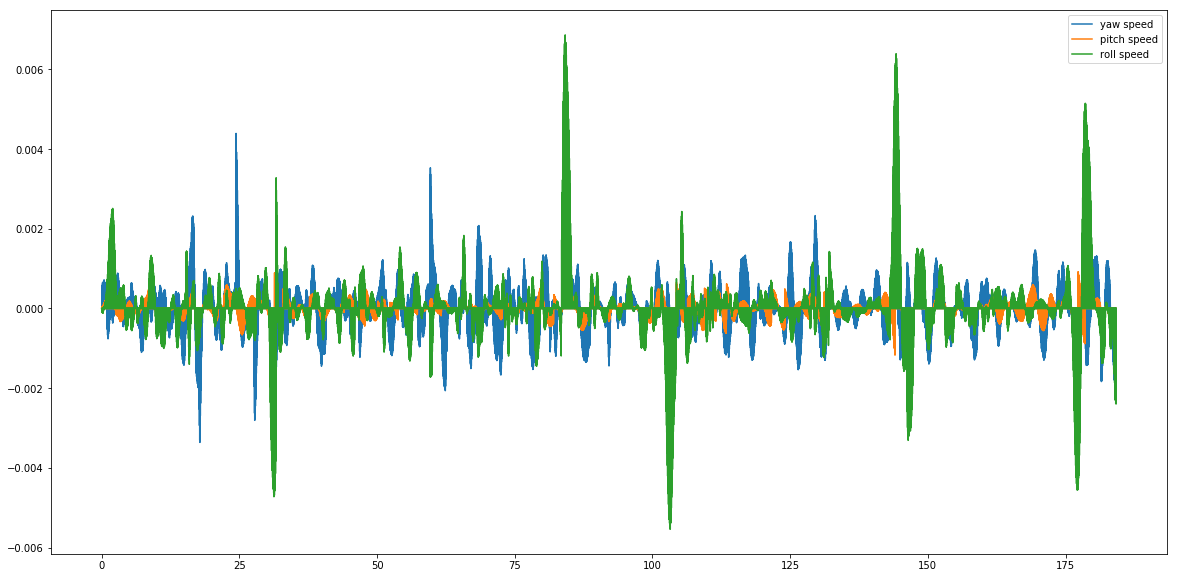

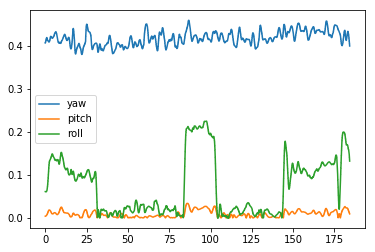

In [7]:
plt.figure(figsize=(20,10))
plt.plot(df['chrono'], accel[:, 0], label='yaw speed')
plt.plot(df['chrono'], accel[:, 1], label='pitch speed')
plt.plot(df['chrono'], accel[:, 2], label='roll speed')
plt.legend()
plt.show()

plt.plot(df['chrono'], angles[:, 0], label='yaw')
plt.plot(df['chrono'], angles[:, 1], label='pitch')
plt.plot(df['chrono'], angles[:, 2], label='roll')
plt.legend()
plt.show()

In [45]:
means =np.mean(accel, axis=0)
stds = np.std(accel, axis=0)
arr = np.hstack([means, stds])
print(arr)
labels = ['AvgYaw', 'AvgPitch', 'AvgRoll', 'StdYaw', 'StdPitch', 'StdRoll']
pd.DataFrame(data=arr, index=labels).T
print(df['chrono'].values[-1])

[-9.53433354e-07  1.46801092e-05 -4.85927427e-06  7.42494060e-04
  1.08958879e-03  3.90128719e-04]
184.1963


In [82]:
stds = df.var(axis=0)
match_cols = sorted(list(stds[stds > 10E-10].index))
print([col for col in match_cols if 'Subject' not in col and '_qua' in col])


['Head_quaw', 'Head_quax', 'Head_quay', 'Head_quaz', 'Jaw_quaw', 'Jaw_quay', 'LeftArmRoll_quaw', 'LeftArmRoll_quax', 'LeftArmRoll_quay', 'LeftArmRoll_quaz', 'LeftArm_quaw', 'LeftArm_quax', 'LeftArm_quay', 'LeftArm_quaz', 'LeftEye_quaw', 'LeftEye_quax', 'LeftEye_quay', 'LeftEye_quaz', 'LeftForeArmRoll_quaw', 'LeftForeArmRoll_quax', 'LeftForeArmRoll_quay', 'LeftForeArmRoll_quaz', 'LeftForeArm_quaw', 'LeftForeArm_quax', 'LeftForeArm_quay', 'LeftForeArm_quaz', 'LeftHandIndex1_quaw', 'LeftHandIndex1_quax', 'LeftHandIndex1_quay', 'LeftHandIndex1_quaz', 'LeftHandIndex2_quaw', 'LeftHandIndex2_quax', 'LeftHandIndex2_quay', 'LeftHandIndex2_quaz', 'LeftHandIndex3_quaw', 'LeftHandIndex3_quax', 'LeftHandIndex3_quay', 'LeftHandIndex3_quaz', 'LeftHandMiddle1_quaw', 'LeftHandMiddle1_quax', 'LeftHandMiddle1_quay', 'LeftHandMiddle1_quaz', 'LeftHandMiddle2_quaw', 'LeftHandMiddle2_quax', 'LeftHandMiddle2_quay', 'LeftHandMiddle2_quaz', 'LeftHandMiddle3_quaw', 'LeftHandMiddle3_quax', 'LeftHandMiddle3_quay',

In [ ]:
print(df.iloc[10]['chrono'])

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation
import pandas as pd


a = np.random.rand(2000, 3)*10
t = np.array([np.ones(100)*i for i in range(20)]).flatten()
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})

def update_graph(num):
    data=df[df['time']==num]
    print(data.shape)
    print(data.x.shape)
    graph.set_data (data.x, data.y)
    graph.set_3d_properties(data.z)
    title.set_text('3D Test, time={}'.format(num))
    return title, graph, 


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('3D Test')

data=df[df['time']==0]
graph, = ax.plot(data.x, data.y, data.z, linestyle="", marker="o")

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 19, 
                               interval=40, blit=True)

plt.show()

In [ ]:
data=df[df['time']==0]
data.x

In [12]:
import numpy as np
from pyquaternion import Quaternion

np.set_printoptions(suppress=True) # Suppress insignificant values for clarity
v = np.array([0., 0., 1.]) # Unit vector in the +z direction
q0 = Quaternion(axis=[1, 1, 1], angle=0.0) # Rotate 0 about x=y=z
q1 = Quaternion(axis=[1, 1, 1], angle=2 * 3.14159265 / 3) # Rotate 120 about x=y=z
for q in Quaternion.intermediates(q0, q1, 8, include_endpoints=True):
    v_prime = q.rotate(v)
    print(v_prime)

[0. 0. 1.]
[ 0.14213118 -0.12416109  0.98202991]
[ 0.29457011 -0.22365854  0.92908843]
[ 0.44909878 -0.29312841  0.84402963]
[ 0.59738651 -0.32882557  0.73143906]
[ 0.73143906 -0.32882557  0.59738651]
[ 0.84402963 -0.29312841  0.44909879]
[ 0.92908843 -0.22365854  0.29457012]
[ 0.98202991 -0.12416109  0.14213118]
[ 1. -0.  0.]


In [17]:
q = Quaternion(x=0.1, y=0.2, z=0.3, w=0.1)
v = np.array([0., 0., 1.])
print(q)
for i in np.arange(10):
    v = q.rotate(v)
    print(v)

0.100 +0.100i +0.200j +0.300k
[0.66666667 0.66666667 0.33333333]
[-0.35555556  0.44444444  0.82222222]
[0.74962963 0.16296296 0.64148148]
[-0.14380247  0.87308642  0.46587654]
[ 0.29962798 -0.07631276  0.95099918]
[0.4244473  0.85918903 0.28572488]
[-0.23533663  0.18705178  0.95374436]
[0.78346953 0.41658789 0.46111823]
[-0.32267722  0.69086254  0.64698405]
[ 0.57583766 -0.01408297  0.81744276]


In [14]:
q

Quaternion(0.0, 0.0, 0.0, 0.0)